In [1]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data.catalog import DatasetCatalog
from detectron2.data.catalog import MetadataCatalog
import numpy as np
from pathlib import Path

In [2]:
#Register train data set
register_coco_instances("train_hail", {}, "./data/fake_hail/202203301504/train.json", "./data/fake_hail/202203301504/images")
dataset_dicts_train = DatasetCatalog.get("train_hail")
hail_metadata_train = MetadataCatalog.get("train_hail")

In [3]:
#Register validation data set
register_coco_instances("val_hail", {}, "./data/fake_hail/202203301504/val.json", "./data/fake_hail/202203301504/images")
dataset_dicts_val = DatasetCatalog.get("val_hail")
hail_metadata_val = MetadataCatalog.get("val_hail")

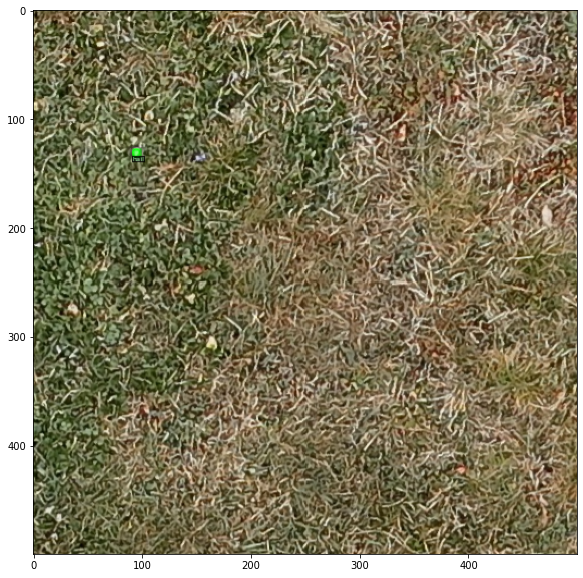

In [4]:
import random
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt

for d in random.sample(dataset_dicts_train, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=hail_metadata_train, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    im = vis.get_image()
    fig=plt.figure(figsize=[12,10])
    plt.imshow(im)

In [20]:
#Download pre-trained model
!wget https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl

--2022-05-04 12:15:56--  https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177841981 (170M) [application/octet-stream]
Saving to: 'model_final_f10217.pkl'

model_final_f10217. 100%[===================>] 169.60M  22.7MB/s    in 8.7s    

2022-05-04 12:16:06 (19.5 MB/s) - 'model_final_f10217.pkl' saved [177841981/177841981]



In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
from detectron2.evaluation import COCOEvaluator

cfg = get_cfg()
cfg.merge_from_file(
    "/home/appuser/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("train_hail",)
cfg.OUTPUT_DIR = "output/fake_hail/202203301504_r3/"
cfg.DATASETS.TEST = ("val_hail",)  # no metrics implemented for this dataset

cfg.DATALOADER.NUM_WORKERS = 1

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.SOLVER.BASE_LR = 0.0002
#cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 40000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (20, 10000, 20000)
cfg.SOLVER.GAMMA = 0.05

# Test
cfg.TEST.EVAL_PERIOD = 200
cfg.TEST.DETECTIONS_PER_IMAGE = 20

cfg.MODEL.WEIGHTS = "model_final_f10217.pkl"  # initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 1 class (hail)
cfg.MODEL.MASK_ON = True
#cfg.MODEL.BACKBONE.NAME = "build_resnet_backbone"
#cfg.MODEL.RESNETS.DEPTH = 101
#cfg.MODEL.RESNETS.RES2_OUT_CHANNELS = 64

cfg.INPUT.MIN_SIZE_TRAIN = (500,)

In [6]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
             
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder='output/fake_hail/202203301504_r3/'):

    if output_folder is None:
        os.makedirs("hail_eval", exist_ok=True)
        output_folder = "hail_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

  def build_hooks(self):
        
    hooks = super().build_hooks()
    hooks.insert(-1,LossEvalHook(
        cfg.TEST.EVAL_PERIOD,
        self.model,
        build_detection_test_loader(
            self.cfg,
            self.cfg.DATASETS.TEST[0],
            DatasetMapper(self.cfg,True)
        )
    ))
    return hooks

In [8]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[11/10 18:40:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/10 18:40:26 d2.data.datasets.coco]: Loaded 72 images in COCO format from ./data/fake_hail/202203301504/train.json
[11/10 18:40:26 d2.data.build]: Removed 0 images with no usable annotations. 72 images left.
[11/10 18:40:26 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    hail    | 107          |
|            |              |
[11/10 18:40:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(500,), max_size=1333, sample_style='choice'), RandomFlip()]
[11/10 18:40:26 d2.data.build]: Using training sampler TrainingSampler
[11/10 18:40:26 d2.data.common]: Serializing 72 elements to byte tensors and concatenating them all ...
[11/10 18:40:26 d2.data.common]: Serialized dataset takes 0.05 MiB
[11/10 18:40:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(500,), max_size=1333, sample_

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[11/10 18:40:43 d2.engine.train_loop]: Starting training from iteration 0


/home/appuser/.local/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/10 18:40:51 d2.utils.events]:  eta: 4:38:24  iter: 19  total_loss: 2.207  loss_cls: 0.5126  loss_box_reg: 0.07897  loss_mask: 0.6871  loss_rpn_cls: 0.6977  loss_rpn_loc: 0.2026  time: 0.3888  data_time: 0.2277  lr: 3.862e-07  max_mem: 1614M
[11/10 18:40:55 d2.utils.events]:  eta: 2:27:34  iter: 39  total_loss: 2.132  loss_cls: 0.5026  loss_box_reg: 0.08799  loss_mask: 0.6849  loss_rpn_cls: 0.6189  loss_rpn_loc: 0.1912  time: 0.2975  data_time: 0.0324  lr: 5.822e-07  max_mem: 1614M
[11/10 18:41:00 d2.utils.events]:  eta: 2:23:11  iter: 59  total_loss: 2.299  loss_cls: 0.4849  loss_box_reg: 0.06423  loss_mask: 0.6809  loss_rpn_cls: 0.8162  loss_rpn_loc: 0.2368  time: 0.2678  data_time: 0.0328  lr: 7.782e-07  max_mem: 1614M
[11/10 18:41:04 d2.utils.events]:  eta: 2:22:03  iter: 79  total_loss: 2.182  loss_cls: 0.4657  loss_box_reg: 0.08823  loss_mask: 0.6759  loss_rpn_cls: 0.7367  loss_rpn_loc: 0.2016  time: 0.2529  data_time: 0.0302  lr: 9.742e-07  max_mem: 1614M
[11/10 18:41:08 d2.u

[11/10 18:41:43 d2.utils.events]:  eta: 2:20:53  iter: 239  total_loss: 1.533  loss_cls: 0.2672  loss_box_reg: 0.09723  loss_mask: 0.5969  loss_rpn_cls: 0.3695  loss_rpn_loc: 0.1886  validation_loss: 1.516  time: 0.2257  data_time: 0.0326  lr: 2.5422e-06  max_mem: 1614M
[11/10 18:41:47 d2.utils.events]:  eta: 2:20:39  iter: 259  total_loss: 1.307  loss_cls: 0.2566  loss_box_reg: 0.1055  loss_mask: 0.584  loss_rpn_cls: 0.2055  loss_rpn_loc: 0.1523  validation_loss: 1.516  time: 0.2246  data_time: 0.0325  lr: 2.7382e-06  max_mem: 1614M
[11/10 18:41:51 d2.utils.events]:  eta: 2:20:35  iter: 279  total_loss: 1.25  loss_cls: 0.2395  loss_box_reg: 0.1109  loss_mask: 0.5754  loss_rpn_cls: 0.2061  loss_rpn_loc: 0.1248  validation_loss: 1.516  time: 0.2238  data_time: 0.0317  lr: 2.9342e-06  max_mem: 1614M
[11/10 18:41:55 d2.utils.events]:  eta: 2:20:28  iter: 299  total_loss: 1.157  loss_cls: 0.2235  loss_box_reg: 0.09927  loss_mask: 0.5568  loss_rpn_cls: 0.1373  loss_rpn_loc: 0.1394  validati

[11/10 18:42:28 d2.utils.events]:  eta: 2:19:58  iter: 439  total_loss: 0.9377  loss_cls: 0.1611  loss_box_reg: 0.1573  loss_mask: 0.4756  loss_rpn_cls: 0.05189  loss_rpn_loc: 0.1043  validation_loss: 1.337  time: 0.2196  data_time: 0.0306  lr: 4.5022e-06  max_mem: 1614M
[11/10 18:42:33 d2.utils.events]:  eta: 2:19:55  iter: 459  total_loss: 0.937  loss_cls: 0.1471  loss_box_reg: 0.141  loss_mask: 0.4677  loss_rpn_cls: 0.05121  loss_rpn_loc: 0.1005  validation_loss: 1.337  time: 0.2194  data_time: 0.0319  lr: 4.6982e-06  max_mem: 1614M
[11/10 18:42:37 d2.utils.events]:  eta: 2:20:05  iter: 479  total_loss: 0.9433  loss_cls: 0.1569  loss_box_reg: 0.1821  loss_mask: 0.4491  loss_rpn_cls: 0.04829  loss_rpn_loc: 0.08296  validation_loss: 1.337  time: 0.2193  data_time: 0.0326  lr: 4.8942e-06  max_mem: 1614M
[11/10 18:42:41 d2.utils.events]:  eta: 2:20:04  iter: 499  total_loss: 0.9445  loss_cls: 0.1392  loss_box_reg: 0.1486  loss_mask: 0.4728  loss_rpn_cls: 0.05423  loss_rpn_loc: 0.08706  

[11/10 18:43:15 d2.utils.events]:  eta: 2:19:56  iter: 639  total_loss: 0.7978  loss_cls: 0.1241  loss_box_reg: 0.1731  loss_mask: 0.4048  loss_rpn_cls: 0.0288  loss_rpn_loc: 0.06426  validation_loss: 1.158  time: 0.2184  data_time: 0.0308  lr: 6.4622e-06  max_mem: 1614M
[11/10 18:43:19 d2.utils.events]:  eta: 2:19:58  iter: 659  total_loss: 0.8109  loss_cls: 0.1206  loss_box_reg: 0.1875  loss_mask: 0.4019  loss_rpn_cls: 0.03215  loss_rpn_loc: 0.07024  validation_loss: 1.158  time: 0.2183  data_time: 0.0329  lr: 6.6582e-06  max_mem: 1614M
[11/10 18:43:24 d2.utils.events]:  eta: 2:20:02  iter: 679  total_loss: 0.8052  loss_cls: 0.1358  loss_box_reg: 0.2053  loss_mask: 0.3806  loss_rpn_cls: 0.0328  loss_rpn_loc: 0.05648  validation_loss: 1.158  time: 0.2184  data_time: 0.0323  lr: 6.8542e-06  max_mem: 1614M
[11/10 18:43:28 d2.utils.events]:  eta: 2:19:58  iter: 699  total_loss: 0.8529  loss_cls: 0.1198  loss_box_reg: 0.1912  loss_mask: 0.3753  loss_rpn_cls: 0.03912  loss_rpn_loc: 0.06808

[11/10 18:44:02 d2.utils.events]:  eta: 2:20:06  iter: 839  total_loss: 0.7626  loss_cls: 0.1077  loss_box_reg: 0.1888  loss_mask: 0.3552  loss_rpn_cls: 0.02875  loss_rpn_loc: 0.06215  validation_loss: 1.019  time: 0.2185  data_time: 0.0328  lr: 8.4222e-06  max_mem: 1614M
[11/10 18:44:07 d2.utils.events]:  eta: 2:20:02  iter: 859  total_loss: 0.7341  loss_cls: 0.11  loss_box_reg: 0.1758  loss_mask: 0.3642  loss_rpn_cls: 0.02002  loss_rpn_loc: 0.05455  validation_loss: 1.019  time: 0.2185  data_time: 0.0318  lr: 8.6182e-06  max_mem: 1614M
[11/10 18:44:11 d2.utils.events]:  eta: 2:20:01  iter: 879  total_loss: 0.7666  loss_cls: 0.1105  loss_box_reg: 0.2012  loss_mask: 0.3642  loss_rpn_cls: 0.03134  loss_rpn_loc: 0.06679  validation_loss: 1.019  time: 0.2185  data_time: 0.0325  lr: 8.8142e-06  max_mem: 1614M
[11/10 18:44:15 d2.utils.events]:  eta: 2:20:00  iter: 899  total_loss: 0.7081  loss_cls: 0.0961  loss_box_reg: 0.1718  loss_mask: 0.3336  loss_rpn_cls: 0.02405  loss_rpn_loc: 0.05529

[11/10 18:44:50 d2.utils.events]:  eta: 2:19:52  iter: 1039  total_loss: 0.7065  loss_cls: 0.09385  loss_box_reg: 0.2026  loss_mask: 0.3348  loss_rpn_cls: 0.02658  loss_rpn_loc: 0.06978  validation_loss: 0.8798  time: 0.2185  data_time: 0.0320  lr: 1e-05  max_mem: 1664M
[11/10 18:44:54 d2.utils.events]:  eta: 2:19:53  iter: 1059  total_loss: 0.6914  loss_cls: 0.08688  loss_box_reg: 0.1742  loss_mask: 0.3365  loss_rpn_cls: 0.02934  loss_rpn_loc: 0.05536  validation_loss: 0.8798  time: 0.2185  data_time: 0.0324  lr: 1e-05  max_mem: 1664M
[11/10 18:44:58 d2.utils.events]:  eta: 2:19:59  iter: 1079  total_loss: 0.7  loss_cls: 0.09134  loss_box_reg: 0.1891  loss_mask: 0.3369  loss_rpn_cls: 0.02386  loss_rpn_loc: 0.05454  validation_loss: 0.8798  time: 0.2186  data_time: 0.0326  lr: 1e-05  max_mem: 1664M
[11/10 18:45:03 d2.utils.events]:  eta: 2:19:57  iter: 1099  total_loss: 0.6715  loss_cls: 0.08992  loss_box_reg: 0.1949  loss_mask: 0.3401  loss_rpn_cls: 0.02335  loss_rpn_loc: 0.05446  val

[11/10 18:45:37 d2.utils.events]:  eta: 2:19:57  iter: 1239  total_loss: 0.6675  loss_cls: 0.07582  loss_box_reg: 0.1798  loss_mask: 0.3275  loss_rpn_cls: 0.02315  loss_rpn_loc: 0.05431  validation_loss: 0.8232  time: 0.2186  data_time: 0.0334  lr: 1e-05  max_mem: 1667M
[11/10 18:45:41 d2.utils.events]:  eta: 2:20:06  iter: 1259  total_loss: 0.716  loss_cls: 0.08281  loss_box_reg: 0.2005  loss_mask: 0.3225  loss_rpn_cls: 0.02457  loss_rpn_loc: 0.05179  validation_loss: 0.8232  time: 0.2187  data_time: 0.0327  lr: 1e-05  max_mem: 1716M
[11/10 18:45:46 d2.utils.events]:  eta: 2:20:08  iter: 1279  total_loss: 0.6741  loss_cls: 0.07954  loss_box_reg: 0.197  loss_mask: 0.3274  loss_rpn_cls: 0.02302  loss_rpn_loc: 0.05343  validation_loss: 0.8232  time: 0.2187  data_time: 0.0321  lr: 1e-05  max_mem: 1716M
[11/10 18:45:50 d2.utils.events]:  eta: 2:20:08  iter: 1299  total_loss: 0.6911  loss_cls: 0.08182  loss_box_reg: 0.2101  loss_mask: 0.3375  loss_rpn_cls: 0.01937  loss_rpn_loc: 0.05617  va

[11/10 18:46:24 d2.utils.events]:  eta: 2:20:04  iter: 1439  total_loss: 0.6448  loss_cls: 0.0716  loss_box_reg: 0.1887  loss_mask: 0.3195  loss_rpn_cls: 0.02175  loss_rpn_loc: 0.05316  validation_loss: 0.7666  time: 0.2187  data_time: 0.0322  lr: 1e-05  max_mem: 1716M
[11/10 18:46:28 d2.utils.events]:  eta: 2:20:01  iter: 1459  total_loss: 0.6773  loss_cls: 0.07467  loss_box_reg: 0.1832  loss_mask: 0.3239  loss_rpn_cls: 0.02231  loss_rpn_loc: 0.05534  validation_loss: 0.7666  time: 0.2187  data_time: 0.0327  lr: 1e-05  max_mem: 1716M
[11/10 18:46:33 d2.utils.events]:  eta: 2:19:58  iter: 1479  total_loss: 0.6583  loss_cls: 0.07155  loss_box_reg: 0.1921  loss_mask: 0.3197  loss_rpn_cls: 0.01957  loss_rpn_loc: 0.0502  validation_loss: 0.7666  time: 0.2187  data_time: 0.0327  lr: 1e-05  max_mem: 1716M
[11/10 18:46:37 d2.utils.events]:  eta: 2:19:54  iter: 1499  total_loss: 0.6677  loss_cls: 0.07031  loss_box_reg: 0.1875  loss_mask: 0.3152  loss_rpn_cls: 0.02424  loss_rpn_loc: 0.05369  va

[11/10 18:47:11 d2.utils.events]:  eta: 2:19:50  iter: 1639  total_loss: 0.6712  loss_cls: 0.06972  loss_box_reg: 0.202  loss_mask: 0.3078  loss_rpn_cls: 0.02278  loss_rpn_loc: 0.05659  validation_loss: 0.7512  time: 0.2188  data_time: 0.0322  lr: 1e-05  max_mem: 1716M
[11/10 18:47:16 d2.utils.events]:  eta: 2:19:48  iter: 1659  total_loss: 0.6026  loss_cls: 0.06381  loss_box_reg: 0.1802  loss_mask: 0.3005  loss_rpn_cls: 0.02138  loss_rpn_loc: 0.04409  validation_loss: 0.7512  time: 0.2188  data_time: 0.0336  lr: 1e-05  max_mem: 1716M
[11/10 18:47:20 d2.utils.events]:  eta: 2:19:43  iter: 1679  total_loss: 0.663  loss_cls: 0.06502  loss_box_reg: 0.2003  loss_mask: 0.3097  loss_rpn_cls: 0.0207  loss_rpn_loc: 0.05426  validation_loss: 0.7512  time: 0.2188  data_time: 0.0322  lr: 1e-05  max_mem: 1716M
[11/10 18:47:24 d2.utils.events]:  eta: 2:19:40  iter: 1699  total_loss: 0.6282  loss_cls: 0.05936  loss_box_reg: 0.1702  loss_mask: 0.291  loss_rpn_cls: 0.01899  loss_rpn_loc: 0.05549  vali

[11/10 18:47:58 d2.utils.events]:  eta: 2:19:09  iter: 1839  total_loss: 0.6303  loss_cls: 0.05603  loss_box_reg: 0.1803  loss_mask: 0.2893  loss_rpn_cls: 0.02201  loss_rpn_loc: 0.05929  validation_loss: 0.7359  time: 0.2189  data_time: 0.0309  lr: 1e-05  max_mem: 1716M
[11/10 18:48:03 d2.utils.events]:  eta: 2:19:05  iter: 1859  total_loss: 0.5784  loss_cls: 0.05455  loss_box_reg: 0.17  loss_mask: 0.2938  loss_rpn_cls: 0.02252  loss_rpn_loc: 0.049  validation_loss: 0.7359  time: 0.2189  data_time: 0.0319  lr: 1e-05  max_mem: 1716M
[11/10 18:48:07 d2.utils.events]:  eta: 2:19:00  iter: 1879  total_loss: 0.603  loss_cls: 0.06059  loss_box_reg: 0.1725  loss_mask: 0.2742  loss_rpn_cls: 0.0221  loss_rpn_loc: 0.04728  validation_loss: 0.7359  time: 0.2189  data_time: 0.0321  lr: 1e-05  max_mem: 1716M
[11/10 18:48:12 d2.utils.events]:  eta: 2:18:56  iter: 1899  total_loss: 0.6129  loss_cls: 0.05784  loss_box_reg: 0.1891  loss_mask: 0.3125  loss_rpn_cls: 0.02158  loss_rpn_loc: 0.0469  validat

[11/10 18:48:46 d2.utils.events]:  eta: 2:18:28  iter: 2039  total_loss: 0.5628  loss_cls: 0.05511  loss_box_reg: 0.1818  loss_mask: 0.2675  loss_rpn_cls: 0.01812  loss_rpn_loc: 0.05236  validation_loss: 0.7024  time: 0.2189  data_time: 0.0320  lr: 1e-05  max_mem: 1716M
[11/10 18:48:50 d2.utils.events]:  eta: 2:18:24  iter: 2059  total_loss: 0.5589  loss_cls: 0.05308  loss_box_reg: 0.1701  loss_mask: 0.2775  loss_rpn_cls: 0.01693  loss_rpn_loc: 0.03625  validation_loss: 0.7024  time: 0.2189  data_time: 0.0325  lr: 1e-05  max_mem: 1716M
[11/10 18:48:55 d2.utils.events]:  eta: 2:18:20  iter: 2079  total_loss: 0.6115  loss_cls: 0.05662  loss_box_reg: 0.1905  loss_mask: 0.2729  loss_rpn_cls: 0.02435  loss_rpn_loc: 0.05522  validation_loss: 0.7024  time: 0.2189  data_time: 0.0327  lr: 1e-05  max_mem: 1716M
[11/10 18:48:59 d2.utils.events]:  eta: 2:18:17  iter: 2099  total_loss: 0.5455  loss_cls: 0.0531  loss_box_reg: 0.1818  loss_mask: 0.2459  loss_rpn_cls: 0.01737  loss_rpn_loc: 0.04093  v

[11/10 18:49:33 d2.utils.events]:  eta: 2:17:48  iter: 2239  total_loss: 0.52  loss_cls: 0.04685  loss_box_reg: 0.172  loss_mask: 0.2574  loss_rpn_cls: 0.01494  loss_rpn_loc: 0.04353  validation_loss: 0.669  time: 0.2190  data_time: 0.0326  lr: 1e-05  max_mem: 1716M
[11/10 18:49:38 d2.utils.events]:  eta: 2:17:42  iter: 2259  total_loss: 0.544  loss_cls: 0.04894  loss_box_reg: 0.1636  loss_mask: 0.2573  loss_rpn_cls: 0.01864  loss_rpn_loc: 0.05329  validation_loss: 0.669  time: 0.2190  data_time: 0.0310  lr: 1e-05  max_mem: 1716M
[11/10 18:49:42 d2.utils.events]:  eta: 2:17:37  iter: 2279  total_loss: 0.5885  loss_cls: 0.05453  loss_box_reg: 0.1832  loss_mask: 0.2772  loss_rpn_cls: 0.0219  loss_rpn_loc: 0.04941  validation_loss: 0.669  time: 0.2190  data_time: 0.0305  lr: 1e-05  max_mem: 1716M
[11/10 18:49:46 d2.utils.events]:  eta: 2:17:27  iter: 2299  total_loss: 0.489  loss_cls: 0.04626  loss_box_reg: 0.1658  loss_mask: 0.2319  loss_rpn_cls: 0.01528  loss_rpn_loc: 0.03766  validatio

[11/10 18:50:20 d2.utils.events]:  eta: 2:16:49  iter: 2439  total_loss: 0.5316  loss_cls: 0.04876  loss_box_reg: 0.164  loss_mask: 0.2418  loss_rpn_cls: 0.01897  loss_rpn_loc: 0.04466  validation_loss: 0.6571  time: 0.2189  data_time: 0.0319  lr: 1e-05  max_mem: 1716M
[11/10 18:50:25 d2.utils.events]:  eta: 2:16:43  iter: 2459  total_loss: 0.5328  loss_cls: 0.0506  loss_box_reg: 0.1588  loss_mask: 0.2437  loss_rpn_cls: 0.02043  loss_rpn_loc: 0.0467  validation_loss: 0.6571  time: 0.2189  data_time: 0.0291  lr: 1e-05  max_mem: 1716M
[11/10 18:50:29 d2.utils.events]:  eta: 2:16:36  iter: 2479  total_loss: 0.5412  loss_cls: 0.05047  loss_box_reg: 0.1737  loss_mask: 0.23  loss_rpn_cls: 0.02042  loss_rpn_loc: 0.04264  validation_loss: 0.6571  time: 0.2189  data_time: 0.0297  lr: 1e-05  max_mem: 1716M
[11/10 18:50:33 d2.utils.events]:  eta: 2:16:33  iter: 2499  total_loss: 0.551  loss_cls: 0.0505  loss_box_reg: 0.1814  loss_mask: 0.2421  loss_rpn_cls: 0.01792  loss_rpn_loc: 0.05152  validat

[11/10 18:51:07 d2.utils.events]:  eta: 2:16:01  iter: 2639  total_loss: 0.5572  loss_cls: 0.04989  loss_box_reg: 0.1888  loss_mask: 0.2325  loss_rpn_cls: 0.01319  loss_rpn_loc: 0.05941  validation_loss: 0.6452  time: 0.2189  data_time: 0.0333  lr: 1e-05  max_mem: 1716M
[11/10 18:51:12 d2.utils.events]:  eta: 2:15:55  iter: 2659  total_loss: 0.4735  loss_cls: 0.04536  loss_box_reg: 0.1488  loss_mask: 0.223  loss_rpn_cls: 0.01495  loss_rpn_loc: 0.03916  validation_loss: 0.6452  time: 0.2189  data_time: 0.0326  lr: 1e-05  max_mem: 1716M
[11/10 18:51:16 d2.utils.events]:  eta: 2:15:50  iter: 2679  total_loss: 0.4884  loss_cls: 0.04243  loss_box_reg: 0.1535  loss_mask: 0.2247  loss_rpn_cls: 0.02062  loss_rpn_loc: 0.04083  validation_loss: 0.6452  time: 0.2189  data_time: 0.0324  lr: 1e-05  max_mem: 1716M
[11/10 18:51:21 d2.utils.events]:  eta: 2:15:48  iter: 2699  total_loss: 0.4946  loss_cls: 0.04721  loss_box_reg: 0.1754  loss_mask: 0.2251  loss_rpn_cls: 0.01845  loss_rpn_loc: 0.04403  v

[11/10 18:51:55 d2.utils.events]:  eta: 2:15:21  iter: 2839  total_loss: 0.453  loss_cls: 0.04389  loss_box_reg: 0.1452  loss_mask: 0.2095  loss_rpn_cls: 0.01775  loss_rpn_loc: 0.03998  validation_loss: 0.6443  time: 0.2190  data_time: 0.0318  lr: 1e-05  max_mem: 1726M
[11/10 18:51:59 d2.utils.events]:  eta: 2:15:18  iter: 2859  total_loss: 0.4854  loss_cls: 0.04435  loss_box_reg: 0.1704  loss_mask: 0.2141  loss_rpn_cls: 0.01768  loss_rpn_loc: 0.05268  validation_loss: 0.6443  time: 0.2190  data_time: 0.0323  lr: 1e-05  max_mem: 1726M
[11/10 18:52:04 d2.utils.events]:  eta: 2:15:13  iter: 2879  total_loss: 0.4547  loss_cls: 0.03882  loss_box_reg: 0.1466  loss_mask: 0.2045  loss_rpn_cls: 0.01839  loss_rpn_loc: 0.04245  validation_loss: 0.6443  time: 0.2190  data_time: 0.0322  lr: 1e-05  max_mem: 1726M
[11/10 18:52:08 d2.utils.events]:  eta: 2:15:08  iter: 2899  total_loss: 0.472  loss_cls: 0.04075  loss_box_reg: 0.1479  loss_mask: 0.2124  loss_rpn_cls: 0.01757  loss_rpn_loc: 0.03951  va

[11/10 18:52:42 d2.utils.events]:  eta: 2:14:40  iter: 3039  total_loss: 0.4369  loss_cls: 0.03748  loss_box_reg: 0.1382  loss_mask: 0.2062  loss_rpn_cls: 0.01509  loss_rpn_loc: 0.03844  validation_loss: 0.6433  time: 0.2191  data_time: 0.0328  lr: 1e-05  max_mem: 1726M
[11/10 18:52:47 d2.utils.events]:  eta: 2:14:36  iter: 3059  total_loss: 0.4531  loss_cls: 0.04297  loss_box_reg: 0.1631  loss_mask: 0.2041  loss_rpn_cls: 0.02002  loss_rpn_loc: 0.04128  validation_loss: 0.6433  time: 0.2191  data_time: 0.0325  lr: 1e-05  max_mem: 1726M
[11/10 18:52:51 d2.utils.events]:  eta: 2:14:31  iter: 3079  total_loss: 0.4535  loss_cls: 0.04139  loss_box_reg: 0.1548  loss_mask: 0.2032  loss_rpn_cls: 0.01951  loss_rpn_loc: 0.04091  validation_loss: 0.6433  time: 0.2191  data_time: 0.0326  lr: 1e-05  max_mem: 1726M
[11/10 18:52:56 d2.utils.events]:  eta: 2:14:26  iter: 3099  total_loss: 0.4404  loss_cls: 0.03857  loss_box_reg: 0.1462  loss_mask: 0.1957  loss_rpn_cls: 0.01689  loss_rpn_loc: 0.03555  

[11/10 18:53:29 d2.utils.events]:  eta: 2:13:55  iter: 3239  total_loss: 0.4359  loss_cls: 0.03647  loss_box_reg: 0.1325  loss_mask: 0.1887  loss_rpn_cls: 0.01579  loss_rpn_loc: 0.0416  validation_loss: 0.6389  time: 0.2191  data_time: 0.0321  lr: 1e-05  max_mem: 1726M
[11/10 18:53:34 d2.utils.events]:  eta: 2:13:53  iter: 3259  total_loss: 0.4389  loss_cls: 0.03843  loss_box_reg: 0.1425  loss_mask: 0.2023  loss_rpn_cls: 0.01503  loss_rpn_loc: 0.04181  validation_loss: 0.6389  time: 0.2191  data_time: 0.0327  lr: 1e-05  max_mem: 1726M
[11/10 18:53:38 d2.utils.events]:  eta: 2:13:49  iter: 3279  total_loss: 0.4588  loss_cls: 0.03937  loss_box_reg: 0.1426  loss_mask: 0.2003  loss_rpn_cls: 0.01667  loss_rpn_loc: 0.04536  validation_loss: 0.6389  time: 0.2191  data_time: 0.0323  lr: 1e-05  max_mem: 1726M
[11/10 18:53:43 d2.utils.events]:  eta: 2:13:46  iter: 3299  total_loss: 0.4237  loss_cls: 0.0358  loss_box_reg: 0.1415  loss_mask: 0.2036  loss_rpn_cls: 0.01454  loss_rpn_loc: 0.03925  va

[11/10 18:54:17 d2.utils.events]:  eta: 2:13:24  iter: 3439  total_loss: 0.427  loss_cls: 0.03448  loss_box_reg: 0.1331  loss_mask: 0.1949  loss_rpn_cls: 0.01348  loss_rpn_loc: 0.04273  validation_loss: 0.6344  time: 0.2191  data_time: 0.0321  lr: 1e-05  max_mem: 1726M
[11/10 18:54:21 d2.utils.events]:  eta: 2:13:21  iter: 3459  total_loss: 0.4227  loss_cls: 0.03361  loss_box_reg: 0.1256  loss_mask: 0.1837  loss_rpn_cls: 0.01501  loss_rpn_loc: 0.03703  validation_loss: 0.6344  time: 0.2191  data_time: 0.0317  lr: 1e-05  max_mem: 1726M
[11/10 18:54:26 d2.utils.events]:  eta: 2:13:18  iter: 3479  total_loss: 0.3994  loss_cls: 0.03673  loss_box_reg: 0.126  loss_mask: 0.1954  loss_rpn_cls: 0.01418  loss_rpn_loc: 0.04617  validation_loss: 0.6344  time: 0.2191  data_time: 0.0324  lr: 1e-05  max_mem: 1726M
[11/10 18:54:30 d2.utils.events]:  eta: 2:13:14  iter: 3499  total_loss: 0.4529  loss_cls: 0.03721  loss_box_reg: 0.1308  loss_mask: 0.1945  loss_rpn_cls: 0.015  loss_rpn_loc: 0.04969  vali

[11/10 18:55:04 d2.utils.events]:  eta: 2:12:43  iter: 3639  total_loss: 0.3927  loss_cls: 0.0362  loss_box_reg: 0.1147  loss_mask: 0.1916  loss_rpn_cls: 0.01637  loss_rpn_loc: 0.04499  validation_loss: 0.6246  time: 0.2191  data_time: 0.0324  lr: 1e-05  max_mem: 1726M
[11/10 18:55:08 d2.utils.events]:  eta: 2:12:39  iter: 3659  total_loss: 0.4269  loss_cls: 0.03468  loss_box_reg: 0.123  loss_mask: 0.1879  loss_rpn_cls: 0.01269  loss_rpn_loc: 0.04385  validation_loss: 0.6246  time: 0.2191  data_time: 0.0311  lr: 1e-05  max_mem: 1726M
[11/10 18:55:13 d2.utils.events]:  eta: 2:12:35  iter: 3679  total_loss: 0.437  loss_cls: 0.0388  loss_box_reg: 0.1412  loss_mask: 0.1838  loss_rpn_cls: 0.01455  loss_rpn_loc: 0.04823  validation_loss: 0.6246  time: 0.2191  data_time: 0.0301  lr: 1e-05  max_mem: 1726M
[11/10 18:55:17 d2.utils.events]:  eta: 2:12:29  iter: 3699  total_loss: 0.3919  loss_cls: 0.03575  loss_box_reg: 0.124  loss_mask: 0.1809  loss_rpn_cls: 0.01688  loss_rpn_loc: 0.03454  valid

[11/10 18:55:51 d2.utils.events]:  eta: 2:11:52  iter: 3839  total_loss: 0.3835  loss_cls: 0.03928  loss_box_reg: 0.1297  loss_mask: 0.1824  loss_rpn_cls: 0.01383  loss_rpn_loc: 0.03536  validation_loss: 0.6148  time: 0.2191  data_time: 0.0314  lr: 1e-05  max_mem: 1726M
[11/10 18:55:55 d2.utils.events]:  eta: 2:11:48  iter: 3859  total_loss: 0.3791  loss_cls: 0.03245  loss_box_reg: 0.1053  loss_mask: 0.1745  loss_rpn_cls: 0.01092  loss_rpn_loc: 0.03606  validation_loss: 0.6148  time: 0.2191  data_time: 0.0328  lr: 1e-05  max_mem: 1726M
[11/10 18:56:00 d2.utils.events]:  eta: 2:11:45  iter: 3879  total_loss: 0.4304  loss_cls: 0.03671  loss_box_reg: 0.1269  loss_mask: 0.1962  loss_rpn_cls: 0.01919  loss_rpn_loc: 0.0526  validation_loss: 0.6148  time: 0.2191  data_time: 0.0323  lr: 1e-05  max_mem: 1726M
[11/10 18:56:04 d2.utils.events]:  eta: 2:11:43  iter: 3899  total_loss: 0.4247  loss_cls: 0.03933  loss_box_reg: 0.1201  loss_mask: 0.1925  loss_rpn_cls: 0.01595  loss_rpn_loc: 0.04198  v

[11/10 18:56:38 d2.utils.events]:  eta: 2:11:10  iter: 4039  total_loss: 0.4132  loss_cls: 0.03837  loss_box_reg: 0.1181  loss_mask: 0.1883  loss_rpn_cls: 0.01453  loss_rpn_loc: 0.05084  validation_loss: 0.6087  time: 0.2191  data_time: 0.0314  lr: 1e-05  max_mem: 1726M
[11/10 18:56:43 d2.utils.events]:  eta: 2:11:04  iter: 4059  total_loss: 0.3844  loss_cls: 0.03313  loss_box_reg: 0.1059  loss_mask: 0.1872  loss_rpn_cls: 0.01796  loss_rpn_loc: 0.03906  validation_loss: 0.6087  time: 0.2191  data_time: 0.0315  lr: 1e-05  max_mem: 1726M
[11/10 18:56:47 d2.utils.events]:  eta: 2:10:59  iter: 4079  total_loss: 0.3707  loss_cls: 0.02995  loss_box_reg: 0.1065  loss_mask: 0.1675  loss_rpn_cls: 0.01426  loss_rpn_loc: 0.03952  validation_loss: 0.6087  time: 0.2191  data_time: 0.0308  lr: 1e-05  max_mem: 1726M
[11/10 18:56:52 d2.utils.events]:  eta: 2:10:57  iter: 4099  total_loss: 0.4102  loss_cls: 0.03423  loss_box_reg: 0.1121  loss_mask: 0.1883  loss_rpn_cls: 0.01565  loss_rpn_loc: 0.03881  

[11/10 18:57:25 d2.utils.events]:  eta: 2:10:27  iter: 4239  total_loss: 0.3608  loss_cls: 0.02901  loss_box_reg: 0.09825  loss_mask: 0.1846  loss_rpn_cls: 0.01355  loss_rpn_loc: 0.03481  validation_loss: 0.5702  time: 0.2191  data_time: 0.0308  lr: 1e-05  max_mem: 1726M
[11/10 18:57:30 d2.utils.events]:  eta: 2:10:22  iter: 4259  total_loss: 0.3777  loss_cls: 0.03246  loss_box_reg: 0.09767  loss_mask: 0.18  loss_rpn_cls: 0.0115  loss_rpn_loc: 0.04299  validation_loss: 0.5702  time: 0.2191  data_time: 0.0322  lr: 1e-05  max_mem: 1726M
[11/10 18:57:34 d2.utils.events]:  eta: 2:10:17  iter: 4279  total_loss: 0.4026  loss_cls: 0.03927  loss_box_reg: 0.1145  loss_mask: 0.1891  loss_rpn_cls: 0.01801  loss_rpn_loc: 0.0454  validation_loss: 0.5702  time: 0.2191  data_time: 0.0302  lr: 1e-05  max_mem: 1726M
[11/10 18:57:39 d2.utils.events]:  eta: 2:10:12  iter: 4299  total_loss: 0.3752  loss_cls: 0.03  loss_box_reg: 0.1029  loss_mask: 0.1779  loss_rpn_cls: 0.01498  loss_rpn_loc: 0.04066  valid

[11/10 18:58:12 d2.utils.events]:  eta: 2:09:40  iter: 4439  total_loss: 0.372  loss_cls: 0.03549  loss_box_reg: 0.1085  loss_mask: 0.1839  loss_rpn_cls: 0.01489  loss_rpn_loc: 0.04239  validation_loss: 0.5314  time: 0.2191  data_time: 0.0316  lr: 1e-05  max_mem: 1726M
[11/10 18:58:17 d2.utils.events]:  eta: 2:09:36  iter: 4459  total_loss: 0.3794  loss_cls: 0.03315  loss_box_reg: 0.09652  loss_mask: 0.192  loss_rpn_cls: 0.01257  loss_rpn_loc: 0.04087  validation_loss: 0.5314  time: 0.2191  data_time: 0.0321  lr: 1e-05  max_mem: 1726M
[11/10 18:58:21 d2.utils.events]:  eta: 2:09:32  iter: 4479  total_loss: 0.3631  loss_cls: 0.03234  loss_box_reg: 0.1034  loss_mask: 0.1763  loss_rpn_cls: 0.01428  loss_rpn_loc: 0.0395  validation_loss: 0.5314  time: 0.2191  data_time: 0.0319  lr: 1e-05  max_mem: 1726M
[11/10 18:58:26 d2.utils.events]:  eta: 2:09:27  iter: 4499  total_loss: 0.3724  loss_cls: 0.02996  loss_box_reg: 0.099  loss_mask: 0.1796  loss_rpn_cls: 0.01482  loss_rpn_loc: 0.03865  val

[11/10 18:59:00 d2.utils.events]:  eta: 2:08:59  iter: 4639  total_loss: 0.3395  loss_cls: 0.02789  loss_box_reg: 0.09402  loss_mask: 0.166  loss_rpn_cls: 0.01483  loss_rpn_loc: 0.0375  validation_loss: 0.5208  time: 0.2191  data_time: 0.0316  lr: 1e-05  max_mem: 1726M
[11/10 18:59:04 d2.utils.events]:  eta: 2:08:56  iter: 4659  total_loss: 0.3549  loss_cls: 0.03579  loss_box_reg: 0.1003  loss_mask: 0.173  loss_rpn_cls: 0.01455  loss_rpn_loc: 0.03647  validation_loss: 0.5208  time: 0.2191  data_time: 0.0317  lr: 1e-05  max_mem: 1726M
[11/10 18:59:08 d2.utils.events]:  eta: 2:08:55  iter: 4679  total_loss: 0.3902  loss_cls: 0.0301  loss_box_reg: 0.09694  loss_mask: 0.1872  loss_rpn_cls: 0.01692  loss_rpn_loc: 0.03622  validation_loss: 0.5208  time: 0.2191  data_time: 0.0313  lr: 1e-05  max_mem: 1726M
[11/10 18:59:13 d2.utils.events]:  eta: 2:08:50  iter: 4699  total_loss: 0.3663  loss_cls: 0.03007  loss_box_reg: 0.09817  loss_mask: 0.1741  loss_rpn_cls: 0.01405  loss_rpn_loc: 0.03797  v

[11/10 18:59:47 d2.utils.events]:  eta: 2:08:22  iter: 4839  total_loss: 0.3715  loss_cls: 0.03419  loss_box_reg: 0.1015  loss_mask: 0.164  loss_rpn_cls: 0.01541  loss_rpn_loc: 0.04069  validation_loss: 0.5162  time: 0.2191  data_time: 0.0325  lr: 1e-05  max_mem: 1726M
[11/10 18:59:51 d2.utils.events]:  eta: 2:08:18  iter: 4859  total_loss: 0.3371  loss_cls: 0.02812  loss_box_reg: 0.08878  loss_mask: 0.1712  loss_rpn_cls: 0.01674  loss_rpn_loc: 0.03503  validation_loss: 0.5162  time: 0.2191  data_time: 0.0325  lr: 1e-05  max_mem: 1726M
[11/10 18:59:55 d2.utils.events]:  eta: 2:08:14  iter: 4879  total_loss: 0.3646  loss_cls: 0.03116  loss_box_reg: 0.1063  loss_mask: 0.1668  loss_rpn_cls: 0.01442  loss_rpn_loc: 0.0393  validation_loss: 0.5162  time: 0.2191  data_time: 0.0323  lr: 1e-05  max_mem: 1726M
[11/10 19:00:00 d2.utils.events]:  eta: 2:08:06  iter: 4899  total_loss: 0.373  loss_cls: 0.02736  loss_box_reg: 0.09046  loss_mask: 0.1712  loss_rpn_cls: 0.01569  loss_rpn_loc: 0.03876  v

[11/10 19:00:34 d2.utils.events]:  eta: 2:07:35  iter: 5039  total_loss: 0.3483  loss_cls: 0.03095  loss_box_reg: 0.09262  loss_mask: 0.1627  loss_rpn_cls: 0.01344  loss_rpn_loc: 0.04169  validation_loss: 0.4904  time: 0.2191  data_time: 0.0309  lr: 1e-05  max_mem: 1726M
[11/10 19:00:38 d2.utils.events]:  eta: 2:07:30  iter: 5059  total_loss: 0.373  loss_cls: 0.02903  loss_box_reg: 0.09966  loss_mask: 0.1767  loss_rpn_cls: 0.01491  loss_rpn_loc: 0.04001  validation_loss: 0.4904  time: 0.2191  data_time: 0.0295  lr: 1e-05  max_mem: 1726M
[11/10 19:00:43 d2.utils.events]:  eta: 2:07:24  iter: 5079  total_loss: 0.3436  loss_cls: 0.02755  loss_box_reg: 0.09491  loss_mask: 0.1736  loss_rpn_cls: 0.008621  loss_rpn_loc: 0.03617  validation_loss: 0.4904  time: 0.2191  data_time: 0.0311  lr: 1e-05  max_mem: 1726M
[11/10 19:00:47 d2.utils.events]:  eta: 2:07:17  iter: 5099  total_loss: 0.3612  loss_cls: 0.0308  loss_box_reg: 0.09024  loss_mask: 0.1729  loss_rpn_cls: 0.01693  loss_rpn_loc: 0.0368

[11/10 19:01:21 d2.utils.events]:  eta: 2:06:45  iter: 5239  total_loss: 0.3355  loss_cls: 0.03289  loss_box_reg: 0.0967  loss_mask: 0.1589  loss_rpn_cls: 0.013  loss_rpn_loc: 0.03522  validation_loss: 0.4614  time: 0.2191  data_time: 0.0287  lr: 1e-05  max_mem: 1726M
[11/10 19:01:25 d2.utils.events]:  eta: 2:06:36  iter: 5259  total_loss: 0.3553  loss_cls: 0.02987  loss_box_reg: 0.0866  loss_mask: 0.1715  loss_rpn_cls: 0.01336  loss_rpn_loc: 0.03919  validation_loss: 0.4614  time: 0.2191  data_time: 0.0309  lr: 1e-05  max_mem: 1726M
[11/10 19:01:30 d2.utils.events]:  eta: 2:06:34  iter: 5279  total_loss: 0.3443  loss_cls: 0.02936  loss_box_reg: 0.09195  loss_mask: 0.1669  loss_rpn_cls: 0.01344  loss_rpn_loc: 0.03675  validation_loss: 0.4614  time: 0.2191  data_time: 0.0324  lr: 1e-05  max_mem: 1726M
[11/10 19:01:34 d2.utils.events]:  eta: 2:06:29  iter: 5299  total_loss: 0.3445  loss_cls: 0.03135  loss_box_reg: 0.09952  loss_mask: 0.1714  loss_rpn_cls: 0.01169  loss_rpn_loc: 0.03848  

[11/10 19:02:08 d2.utils.events]:  eta: 2:05:52  iter: 5439  total_loss: 0.3387  loss_cls: 0.02861  loss_box_reg: 0.08886  loss_mask: 0.1648  loss_rpn_cls: 0.01354  loss_rpn_loc: 0.03461  validation_loss: 0.4514  time: 0.2191  data_time: 0.0322  lr: 1e-05  max_mem: 1726M
[11/10 19:02:12 d2.utils.events]:  eta: 2:05:46  iter: 5459  total_loss: 0.338  loss_cls: 0.02689  loss_box_reg: 0.08852  loss_mask: 0.1705  loss_rpn_cls: 0.01549  loss_rpn_loc: 0.03234  validation_loss: 0.4514  time: 0.2191  data_time: 0.0309  lr: 1e-05  max_mem: 1726M
[11/10 19:02:16 d2.utils.events]:  eta: 2:05:44  iter: 5479  total_loss: 0.3379  loss_cls: 0.02713  loss_box_reg: 0.08648  loss_mask: 0.1574  loss_rpn_cls: 0.01287  loss_rpn_loc: 0.03556  validation_loss: 0.4514  time: 0.2191  data_time: 0.0315  lr: 1e-05  max_mem: 1726M
[11/10 19:02:21 d2.utils.events]:  eta: 2:05:38  iter: 5499  total_loss: 0.3525  loss_cls: 0.02916  loss_box_reg: 0.1002  loss_mask: 0.1724  loss_rpn_cls: 0.01359  loss_rpn_loc: 0.03947

[11/10 19:02:55 d2.utils.events]:  eta: 2:05:04  iter: 5639  total_loss: 0.3386  loss_cls: 0.02543  loss_box_reg: 0.09334  loss_mask: 0.17  loss_rpn_cls: 0.01362  loss_rpn_loc: 0.03145  validation_loss: 0.443  time: 0.2191  data_time: 0.0320  lr: 1e-05  max_mem: 1726M
[11/10 19:02:59 d2.utils.events]:  eta: 2:04:59  iter: 5659  total_loss: 0.3485  loss_cls: 0.03313  loss_box_reg: 0.09547  loss_mask: 0.1696  loss_rpn_cls: 0.01585  loss_rpn_loc: 0.03968  validation_loss: 0.443  time: 0.2191  data_time: 0.0308  lr: 1e-05  max_mem: 1726M
[11/10 19:03:03 d2.utils.events]:  eta: 2:04:55  iter: 5679  total_loss: 0.3301  loss_cls: 0.0252  loss_box_reg: 0.08871  loss_mask: 0.1665  loss_rpn_cls: 0.01283  loss_rpn_loc: 0.03462  validation_loss: 0.443  time: 0.2191  data_time: 0.0326  lr: 1e-05  max_mem: 1726M
[11/10 19:03:08 d2.utils.events]:  eta: 2:04:54  iter: 5699  total_loss: 0.3572  loss_cls: 0.02839  loss_box_reg: 0.1015  loss_mask: 0.1647  loss_rpn_cls: 0.01441  loss_rpn_loc: 0.04268  val

[11/10 19:03:42 d2.utils.events]:  eta: 2:04:27  iter: 5839  total_loss: 0.3441  loss_cls: 0.0284  loss_box_reg: 0.09042  loss_mask: 0.162  loss_rpn_cls: 0.01347  loss_rpn_loc: 0.03175  validation_loss: 0.4361  time: 0.2191  data_time: 0.0319  lr: 1e-05  max_mem: 1726M
[11/10 19:03:46 d2.utils.events]:  eta: 2:04:22  iter: 5859  total_loss: 0.3132  loss_cls: 0.02612  loss_box_reg: 0.08485  loss_mask: 0.16  loss_rpn_cls: 0.01041  loss_rpn_loc: 0.03708  validation_loss: 0.4361  time: 0.2191  data_time: 0.0323  lr: 1e-05  max_mem: 1726M
[11/10 19:03:51 d2.utils.events]:  eta: 2:04:16  iter: 5879  total_loss: 0.3427  loss_cls: 0.02738  loss_box_reg: 0.08525  loss_mask: 0.1804  loss_rpn_cls: 0.01481  loss_rpn_loc: 0.0465  validation_loss: 0.4361  time: 0.2191  data_time: 0.0317  lr: 1e-05  max_mem: 1726M
[11/10 19:03:55 d2.utils.events]:  eta: 2:04:12  iter: 5899  total_loss: 0.3409  loss_cls: 0.02601  loss_box_reg: 0.09028  loss_mask: 0.1596  loss_rpn_cls: 0.01176  loss_rpn_loc: 0.03559  v

[11/10 19:04:29 d2.utils.events]:  eta: 2:03:52  iter: 6039  total_loss: 0.3314  loss_cls: 0.02691  loss_box_reg: 0.09286  loss_mask: 0.1631  loss_rpn_cls: 0.01343  loss_rpn_loc: 0.03761  validation_loss: 0.4304  time: 0.2192  data_time: 0.0324  lr: 1e-05  max_mem: 1726M
[11/10 19:04:34 d2.utils.events]:  eta: 2:03:48  iter: 6059  total_loss: 0.3293  loss_cls: 0.0281  loss_box_reg: 0.08605  loss_mask: 0.1566  loss_rpn_cls: 0.01112  loss_rpn_loc: 0.0373  validation_loss: 0.4304  time: 0.2192  data_time: 0.0327  lr: 1e-05  max_mem: 1726M
[11/10 19:04:38 d2.utils.events]:  eta: 2:03:45  iter: 6079  total_loss: 0.328  loss_cls: 0.02582  loss_box_reg: 0.09174  loss_mask: 0.1494  loss_rpn_cls: 0.01248  loss_rpn_loc: 0.03675  validation_loss: 0.4304  time: 0.2192  data_time: 0.0332  lr: 1e-05  max_mem: 1726M
[11/10 19:04:43 d2.utils.events]:  eta: 2:03:43  iter: 6099  total_loss: 0.3228  loss_cls: 0.02682  loss_box_reg: 0.08677  loss_mask: 0.1631  loss_rpn_cls: 0.01199  loss_rpn_loc: 0.03384 

[11/10 19:05:17 d2.utils.events]:  eta: 2:03:18  iter: 6239  total_loss: 0.3303  loss_cls: 0.02502  loss_box_reg: 0.09267  loss_mask: 0.1688  loss_rpn_cls: 0.01372  loss_rpn_loc: 0.03393  validation_loss: 0.4295  time: 0.2192  data_time: 0.0328  lr: 1e-05  max_mem: 1726M
[11/10 19:05:21 d2.utils.events]:  eta: 2:03:13  iter: 6259  total_loss: 0.3224  loss_cls: 0.02442  loss_box_reg: 0.08697  loss_mask: 0.153  loss_rpn_cls: 0.01495  loss_rpn_loc: 0.03812  validation_loss: 0.4295  time: 0.2192  data_time: 0.0311  lr: 1e-05  max_mem: 1726M
[11/10 19:05:25 d2.utils.events]:  eta: 2:03:09  iter: 6279  total_loss: 0.3291  loss_cls: 0.02555  loss_box_reg: 0.08354  loss_mask: 0.1594  loss_rpn_cls: 0.01318  loss_rpn_loc: 0.03499  validation_loss: 0.4295  time: 0.2192  data_time: 0.0317  lr: 1e-05  max_mem: 1726M
[11/10 19:05:30 d2.utils.events]:  eta: 2:03:03  iter: 6299  total_loss: 0.3468  loss_cls: 0.02706  loss_box_reg: 0.08873  loss_mask: 0.1619  loss_rpn_cls: 0.0121  loss_rpn_loc: 0.03447

[11/10 19:06:04 d2.utils.events]:  eta: 2:02:41  iter: 6439  total_loss: 0.3245  loss_cls: 0.02888  loss_box_reg: 0.08521  loss_mask: 0.1511  loss_rpn_cls: 0.01559  loss_rpn_loc: 0.03587  validation_loss: 0.4287  time: 0.2192  data_time: 0.0323  lr: 1e-05  max_mem: 1726M
[11/10 19:06:08 d2.utils.events]:  eta: 2:02:37  iter: 6459  total_loss: 0.3281  loss_cls: 0.02595  loss_box_reg: 0.08444  loss_mask: 0.1648  loss_rpn_cls: 0.01279  loss_rpn_loc: 0.03435  validation_loss: 0.4287  time: 0.2192  data_time: 0.0323  lr: 1e-05  max_mem: 1726M
[11/10 19:06:12 d2.utils.events]:  eta: 2:02:31  iter: 6479  total_loss: 0.3456  loss_cls: 0.02707  loss_box_reg: 0.09421  loss_mask: 0.1619  loss_rpn_cls: 0.01411  loss_rpn_loc: 0.03105  validation_loss: 0.4287  time: 0.2192  data_time: 0.0302  lr: 1e-05  max_mem: 1726M
[11/10 19:06:17 d2.utils.events]:  eta: 2:02:24  iter: 6499  total_loss: 0.3056  loss_cls: 0.02481  loss_box_reg: 0.0871  loss_mask: 0.1563  loss_rpn_cls: 0.009659  loss_rpn_loc: 0.032

[11/10 19:06:50 d2.utils.events]:  eta: 2:01:54  iter: 6639  total_loss: 0.3289  loss_cls: 0.02645  loss_box_reg: 0.08746  loss_mask: 0.1597  loss_rpn_cls: 0.01217  loss_rpn_loc: 0.03219  validation_loss: 0.4274  time: 0.2192  data_time: 0.0327  lr: 1e-05  max_mem: 1726M
[11/10 19:06:55 d2.utils.events]:  eta: 2:01:51  iter: 6659  total_loss: 0.3396  loss_cls: 0.02663  loss_box_reg: 0.08761  loss_mask: 0.1649  loss_rpn_cls: 0.01388  loss_rpn_loc: 0.0361  validation_loss: 0.4274  time: 0.2192  data_time: 0.0319  lr: 1e-05  max_mem: 1726M
[11/10 19:06:59 d2.utils.events]:  eta: 2:01:46  iter: 6679  total_loss: 0.3319  loss_cls: 0.02822  loss_box_reg: 0.07963  loss_mask: 0.1572  loss_rpn_cls: 0.009946  loss_rpn_loc: 0.03756  validation_loss: 0.4274  time: 0.2192  data_time: 0.0306  lr: 1e-05  max_mem: 1726M
[11/10 19:07:04 d2.utils.events]:  eta: 2:01:38  iter: 6699  total_loss: 0.32  loss_cls: 0.02623  loss_box_reg: 0.07895  loss_mask: 0.164  loss_rpn_cls: 0.01392  loss_rpn_loc: 0.02827 

[11/10 19:07:37 d2.utils.events]:  eta: 2:01:06  iter: 6839  total_loss: 0.3283  loss_cls: 0.02853  loss_box_reg: 0.08769  loss_mask: 0.1565  loss_rpn_cls: 0.0148  loss_rpn_loc: 0.03628  validation_loss: 0.4274  time: 0.2192  data_time: 0.0319  lr: 1e-05  max_mem: 1726M
[11/10 19:07:42 d2.utils.events]:  eta: 2:01:04  iter: 6859  total_loss: 0.3386  loss_cls: 0.02636  loss_box_reg: 0.09133  loss_mask: 0.1554  loss_rpn_cls: 0.01188  loss_rpn_loc: 0.03569  validation_loss: 0.4274  time: 0.2192  data_time: 0.0318  lr: 1e-05  max_mem: 1726M
[11/10 19:07:46 d2.utils.events]:  eta: 2:00:58  iter: 6879  total_loss: 0.3148  loss_cls: 0.02692  loss_box_reg: 0.08707  loss_mask: 0.153  loss_rpn_cls: 0.0132  loss_rpn_loc: 0.03011  validation_loss: 0.4274  time: 0.2192  data_time: 0.0304  lr: 1e-05  max_mem: 1726M
[11/10 19:07:51 d2.utils.events]:  eta: 2:00:56  iter: 6899  total_loss: 0.3398  loss_cls: 0.02661  loss_box_reg: 0.08626  loss_mask: 0.1626  loss_rpn_cls: 0.01015  loss_rpn_loc: 0.03586 

[11/10 19:08:25 d2.utils.events]:  eta: 2:00:19  iter: 7039  total_loss: 0.3251  loss_cls: 0.02343  loss_box_reg: 0.08305  loss_mask: 0.1565  loss_rpn_cls: 0.01268  loss_rpn_loc: 0.03595  validation_loss: 0.4248  time: 0.2192  data_time: 0.0320  lr: 1e-05  max_mem: 1726M
[11/10 19:08:29 d2.utils.events]:  eta: 2:00:15  iter: 7059  total_loss: 0.3017  loss_cls: 0.02266  loss_box_reg: 0.07625  loss_mask: 0.1464  loss_rpn_cls: 0.009492  loss_rpn_loc: 0.03377  validation_loss: 0.4248  time: 0.2192  data_time: 0.0308  lr: 1e-05  max_mem: 1726M
[11/10 19:08:34 d2.utils.events]:  eta: 2:00:11  iter: 7079  total_loss: 0.3204  loss_cls: 0.02418  loss_box_reg: 0.08334  loss_mask: 0.1585  loss_rpn_cls: 0.01267  loss_rpn_loc: 0.03453  validation_loss: 0.4248  time: 0.2192  data_time: 0.0325  lr: 1e-05  max_mem: 1726M
[11/10 19:08:38 d2.utils.events]:  eta: 2:00:07  iter: 7099  total_loss: 0.3309  loss_cls: 0.02576  loss_box_reg: 0.07862  loss_mask: 0.1552  loss_rpn_cls: 0.01333  loss_rpn_loc: 0.03

[11/10 19:09:12 d2.utils.events]:  eta: 1:59:34  iter: 7239  total_loss: 0.3235  loss_cls: 0.0248  loss_box_reg: 0.08616  loss_mask: 0.1527  loss_rpn_cls: 0.01053  loss_rpn_loc: 0.03529  validation_loss: 0.4227  time: 0.2192  data_time: 0.0318  lr: 1e-05  max_mem: 1726M
[11/10 19:09:17 d2.utils.events]:  eta: 1:59:31  iter: 7259  total_loss: 0.3253  loss_cls: 0.0244  loss_box_reg: 0.07813  loss_mask: 0.1621  loss_rpn_cls: 0.01347  loss_rpn_loc: 0.03678  validation_loss: 0.4227  time: 0.2192  data_time: 0.0323  lr: 1e-05  max_mem: 1726M
[11/10 19:09:21 d2.utils.events]:  eta: 1:59:27  iter: 7279  total_loss: 0.3207  loss_cls: 0.02487  loss_box_reg: 0.08085  loss_mask: 0.1595  loss_rpn_cls: 0.01147  loss_rpn_loc: 0.03052  validation_loss: 0.4227  time: 0.2192  data_time: 0.0321  lr: 1e-05  max_mem: 1726M
[11/10 19:09:26 d2.utils.events]:  eta: 1:59:26  iter: 7299  total_loss: 0.3416  loss_cls: 0.02644  loss_box_reg: 0.09294  loss_mask: 0.1643  loss_rpn_cls: 0.01222  loss_rpn_loc: 0.03679

[11/10 19:09:59 d2.utils.events]:  eta: 1:58:59  iter: 7439  total_loss: 0.3164  loss_cls: 0.02568  loss_box_reg: 0.08801  loss_mask: 0.1461  loss_rpn_cls: 0.01092  loss_rpn_loc: 0.03127  validation_loss: 0.422  time: 0.2192  data_time: 0.0318  lr: 1e-05  max_mem: 1726M
[11/10 19:10:04 d2.utils.events]:  eta: 1:58:54  iter: 7459  total_loss: 0.3308  loss_cls: 0.02397  loss_box_reg: 0.07951  loss_mask: 0.1554  loss_rpn_cls: 0.01174  loss_rpn_loc: 0.03134  validation_loss: 0.422  time: 0.2192  data_time: 0.0325  lr: 1e-05  max_mem: 1726M
[11/10 19:10:08 d2.utils.events]:  eta: 1:58:51  iter: 7479  total_loss: 0.3172  loss_cls: 0.02639  loss_box_reg: 0.09069  loss_mask: 0.1582  loss_rpn_cls: 0.008831  loss_rpn_loc: 0.03328  validation_loss: 0.422  time: 0.2192  data_time: 0.0322  lr: 1e-05  max_mem: 1726M
[11/10 19:10:13 d2.utils.events]:  eta: 1:58:48  iter: 7499  total_loss: 0.3034  loss_cls: 0.02478  loss_box_reg: 0.08021  loss_mask: 0.1516  loss_rpn_cls: 0.01144  loss_rpn_loc: 0.03132

[11/10 19:10:46 d2.utils.events]:  eta: 1:58:21  iter: 7639  total_loss: 0.2998  loss_cls: 0.02125  loss_box_reg: 0.07859  loss_mask: 0.1447  loss_rpn_cls: 0.01267  loss_rpn_loc: 0.02857  validation_loss: 0.422  time: 0.2192  data_time: 0.0319  lr: 1e-05  max_mem: 1726M
[11/10 19:10:51 d2.utils.events]:  eta: 1:58:14  iter: 7659  total_loss: 0.3103  loss_cls: 0.02271  loss_box_reg: 0.08116  loss_mask: 0.1533  loss_rpn_cls: 0.01075  loss_rpn_loc: 0.03037  validation_loss: 0.422  time: 0.2192  data_time: 0.0304  lr: 1e-05  max_mem: 1726M
[11/10 19:10:55 d2.utils.events]:  eta: 1:58:10  iter: 7679  total_loss: 0.2994  loss_cls: 0.02486  loss_box_reg: 0.07888  loss_mask: 0.1523  loss_rpn_cls: 0.01107  loss_rpn_loc: 0.03202  validation_loss: 0.422  time: 0.2192  data_time: 0.0296  lr: 1e-05  max_mem: 1726M
[11/10 19:10:59 d2.utils.events]:  eta: 1:58:06  iter: 7699  total_loss: 0.3216  loss_cls: 0.0229  loss_box_reg: 0.0887  loss_mask: 0.1583  loss_rpn_cls: 0.01372  loss_rpn_loc: 0.03677  v

[11/10 19:11:33 d2.utils.events]:  eta: 1:57:35  iter: 7839  total_loss: 0.3248  loss_cls: 0.02493  loss_box_reg: 0.08295  loss_mask: 0.158  loss_rpn_cls: 0.01058  loss_rpn_loc: 0.03404  validation_loss: 0.4157  time: 0.2192  data_time: 0.0327  lr: 1e-05  max_mem: 1726M
[11/10 19:11:37 d2.utils.events]:  eta: 1:57:29  iter: 7859  total_loss: 0.3015  loss_cls: 0.02318  loss_box_reg: 0.0777  loss_mask: 0.1522  loss_rpn_cls: 0.01084  loss_rpn_loc: 0.03801  validation_loss: 0.4157  time: 0.2192  data_time: 0.0303  lr: 1e-05  max_mem: 1726M
[11/10 19:11:42 d2.utils.events]:  eta: 1:57:26  iter: 7879  total_loss: 0.3167  loss_cls: 0.02453  loss_box_reg: 0.0846  loss_mask: 0.1521  loss_rpn_cls: 0.01015  loss_rpn_loc: 0.03254  validation_loss: 0.4157  time: 0.2192  data_time: 0.0321  lr: 1e-05  max_mem: 1726M
[11/10 19:11:46 d2.utils.events]:  eta: 1:57:21  iter: 7899  total_loss: 0.321  loss_cls: 0.02486  loss_box_reg: 0.08356  loss_mask: 0.1511  loss_rpn_cls: 0.01146  loss_rpn_loc: 0.02998  

[11/10 19:12:21 d2.utils.events]:  eta: 1:56:54  iter: 8039  total_loss: 0.3187  loss_cls: 0.02523  loss_box_reg: 0.08269  loss_mask: 0.1578  loss_rpn_cls: 0.01206  loss_rpn_loc: 0.03215  validation_loss: 0.4193  time: 0.2192  data_time: 0.0331  lr: 1e-05  max_mem: 1726M
[11/10 19:12:25 d2.utils.events]:  eta: 1:56:47  iter: 8059  total_loss: 0.2832  loss_cls: 0.02474  loss_box_reg: 0.07609  loss_mask: 0.1381  loss_rpn_cls: 0.009828  loss_rpn_loc: 0.03178  validation_loss: 0.4193  time: 0.2192  data_time: 0.0325  lr: 1e-05  max_mem: 1726M
[11/10 19:12:29 d2.utils.events]:  eta: 1:56:44  iter: 8079  total_loss: 0.3118  loss_cls: 0.02244  loss_box_reg: 0.07796  loss_mask: 0.1561  loss_rpn_cls: 0.01231  loss_rpn_loc: 0.03667  validation_loss: 0.4193  time: 0.2192  data_time: 0.0323  lr: 1e-05  max_mem: 1726M
[11/10 19:12:34 d2.utils.events]:  eta: 1:56:37  iter: 8099  total_loss: 0.2948  loss_cls: 0.02216  loss_box_reg: 0.07537  loss_mask: 0.1536  loss_rpn_cls: 0.01241  loss_rpn_loc: 0.03

[11/10 19:13:08 d2.utils.events]:  eta: 1:56:05  iter: 8239  total_loss: 0.3038  loss_cls: 0.02499  loss_box_reg: 0.08456  loss_mask: 0.148  loss_rpn_cls: 0.01452  loss_rpn_loc: 0.02994  validation_loss: 0.4193  time: 0.2192  data_time: 0.0328  lr: 1e-05  max_mem: 1726M
[11/10 19:13:12 d2.utils.events]:  eta: 1:56:01  iter: 8259  total_loss: 0.315  loss_cls: 0.02431  loss_box_reg: 0.0777  loss_mask: 0.1509  loss_rpn_cls: 0.01067  loss_rpn_loc: 0.0322  validation_loss: 0.4193  time: 0.2192  data_time: 0.0318  lr: 1e-05  max_mem: 1726M
[11/10 19:13:16 d2.utils.events]:  eta: 1:55:57  iter: 8279  total_loss: 0.3123  loss_cls: 0.0273  loss_box_reg: 0.08345  loss_mask: 0.1504  loss_rpn_cls: 0.01014  loss_rpn_loc: 0.02918  validation_loss: 0.4193  time: 0.2192  data_time: 0.0324  lr: 1e-05  max_mem: 1726M
[11/10 19:13:21 d2.utils.events]:  eta: 1:55:52  iter: 8299  total_loss: 0.304  loss_cls: 0.02212  loss_box_reg: 0.07906  loss_mask: 0.1497  loss_rpn_cls: 0.01068  loss_rpn_loc: 0.02914  va

[11/10 19:13:55 d2.utils.events]:  eta: 1:55:15  iter: 8439  total_loss: 0.2863  loss_cls: 0.02275  loss_box_reg: 0.07186  loss_mask: 0.1484  loss_rpn_cls: 0.01244  loss_rpn_loc: 0.02813  validation_loss: 0.4193  time: 0.2192  data_time: 0.0313  lr: 1e-05  max_mem: 1726M
[11/10 19:13:59 d2.utils.events]:  eta: 1:55:11  iter: 8459  total_loss: 0.2938  loss_cls: 0.02134  loss_box_reg: 0.08062  loss_mask: 0.1365  loss_rpn_cls: 0.01319  loss_rpn_loc: 0.032  validation_loss: 0.4193  time: 0.2192  data_time: 0.0318  lr: 1e-05  max_mem: 1726M
[11/10 19:14:04 d2.utils.events]:  eta: 1:55:06  iter: 8479  total_loss: 0.3119  loss_cls: 0.02403  loss_box_reg: 0.08605  loss_mask: 0.15  loss_rpn_cls: 0.01324  loss_rpn_loc: 0.0354  validation_loss: 0.4193  time: 0.2192  data_time: 0.0310  lr: 1e-05  max_mem: 1726M
[11/10 19:14:08 d2.utils.events]:  eta: 1:55:03  iter: 8499  total_loss: 0.2933  loss_cls: 0.02186  loss_box_reg: 0.07354  loss_mask: 0.1483  loss_rpn_cls: 0.00955  loss_rpn_loc: 0.03174  v

[11/10 19:14:42 d2.utils.events]:  eta: 1:54:27  iter: 8639  total_loss: 0.2884  loss_cls: 0.02113  loss_box_reg: 0.07413  loss_mask: 0.148  loss_rpn_cls: 0.01194  loss_rpn_loc: 0.0318  validation_loss: 0.4108  time: 0.2192  data_time: 0.0328  lr: 1e-05  max_mem: 1726M
[11/10 19:14:46 d2.utils.events]:  eta: 1:54:24  iter: 8659  total_loss: 0.2804  loss_cls: 0.02346  loss_box_reg: 0.07384  loss_mask: 0.1462  loss_rpn_cls: 0.01172  loss_rpn_loc: 0.0338  validation_loss: 0.4108  time: 0.2192  data_time: 0.0319  lr: 1e-05  max_mem: 1726M
[11/10 19:14:51 d2.utils.events]:  eta: 1:54:22  iter: 8679  total_loss: 0.2904  loss_cls: 0.02229  loss_box_reg: 0.07381  loss_mask: 0.1481  loss_rpn_cls: 0.01192  loss_rpn_loc: 0.02965  validation_loss: 0.4108  time: 0.2192  data_time: 0.0321  lr: 1e-05  max_mem: 1726M
[11/10 19:14:55 d2.utils.events]:  eta: 1:54:17  iter: 8699  total_loss: 0.298  loss_cls: 0.01941  loss_box_reg: 0.08069  loss_mask: 0.1464  loss_rpn_cls: 0.01365  loss_rpn_loc: 0.03436  

[11/10 19:15:29 d2.utils.events]:  eta: 1:53:43  iter: 8839  total_loss: 0.2906  loss_cls: 0.02384  loss_box_reg: 0.0735  loss_mask: 0.1436  loss_rpn_cls: 0.01313  loss_rpn_loc: 0.03309  validation_loss: 0.4026  time: 0.2193  data_time: 0.0320  lr: 1e-05  max_mem: 1726M
[11/10 19:15:33 d2.utils.events]:  eta: 1:53:40  iter: 8859  total_loss: 0.2729  loss_cls: 0.02149  loss_box_reg: 0.07306  loss_mask: 0.1539  loss_rpn_cls: 0.01027  loss_rpn_loc: 0.02917  validation_loss: 0.4026  time: 0.2193  data_time: 0.0319  lr: 1e-05  max_mem: 1726M
[11/10 19:15:38 d2.utils.events]:  eta: 1:53:35  iter: 8879  total_loss: 0.2973  loss_cls: 0.02277  loss_box_reg: 0.08106  loss_mask: 0.1425  loss_rpn_cls: 0.01259  loss_rpn_loc: 0.0299  validation_loss: 0.4026  time: 0.2193  data_time: 0.0327  lr: 1e-05  max_mem: 1726M
[11/10 19:15:42 d2.utils.events]:  eta: 1:53:28  iter: 8899  total_loss: 0.297  loss_cls: 0.02285  loss_box_reg: 0.0739  loss_mask: 0.1521  loss_rpn_cls: 0.01199  loss_rpn_loc: 0.0335  v

[11/10 19:16:16 d2.utils.events]:  eta: 1:52:58  iter: 9039  total_loss: 0.2906  loss_cls: 0.01795  loss_box_reg: 0.07073  loss_mask: 0.1467  loss_rpn_cls: 0.01375  loss_rpn_loc: 0.02742  validation_loss: 0.4026  time: 0.2193  data_time: 0.0325  lr: 1e-05  max_mem: 1726M
[11/10 19:16:21 d2.utils.events]:  eta: 1:52:54  iter: 9059  total_loss: 0.2855  loss_cls: 0.0213  loss_box_reg: 0.07642  loss_mask: 0.1416  loss_rpn_cls: 0.01088  loss_rpn_loc: 0.03187  validation_loss: 0.4026  time: 0.2193  data_time: 0.0298  lr: 1e-05  max_mem: 1726M
[11/10 19:16:25 d2.utils.events]:  eta: 1:52:47  iter: 9079  total_loss: 0.2949  loss_cls: 0.02129  loss_box_reg: 0.07936  loss_mask: 0.147  loss_rpn_cls: 0.01206  loss_rpn_loc: 0.03444  validation_loss: 0.4026  time: 0.2193  data_time: 0.0308  lr: 1e-05  max_mem: 1726M
[11/10 19:16:29 d2.utils.events]:  eta: 1:52:44  iter: 9099  total_loss: 0.3096  loss_cls: 0.02238  loss_box_reg: 0.07696  loss_mask: 0.1532  loss_rpn_cls: 0.01217  loss_rpn_loc: 0.03169

[11/10 19:17:03 d2.utils.events]:  eta: 1:52:10  iter: 9239  total_loss: 0.2887  loss_cls: 0.02282  loss_box_reg: 0.0825  loss_mask: 0.1434  loss_rpn_cls: 0.01469  loss_rpn_loc: 0.02712  validation_loss: 0.4026  time: 0.2193  data_time: 0.0317  lr: 1e-05  max_mem: 1726M
[11/10 19:17:07 d2.utils.events]:  eta: 1:52:09  iter: 9259  total_loss: 0.3  loss_cls: 0.02236  loss_box_reg: 0.07166  loss_mask: 0.1397  loss_rpn_cls: 0.01058  loss_rpn_loc: 0.02959  validation_loss: 0.4026  time: 0.2193  data_time: 0.0323  lr: 1e-05  max_mem: 1726M
[11/10 19:17:12 d2.utils.events]:  eta: 1:52:04  iter: 9279  total_loss: 0.3015  loss_cls: 0.02475  loss_box_reg: 0.07505  loss_mask: 0.1406  loss_rpn_cls: 0.007288  loss_rpn_loc: 0.0347  validation_loss: 0.4026  time: 0.2193  data_time: 0.0325  lr: 1e-05  max_mem: 1726M
[11/10 19:17:16 d2.utils.events]:  eta: 1:51:56  iter: 9299  total_loss: 0.2803  loss_cls: 0.02373  loss_box_reg: 0.07449  loss_mask: 0.1456  loss_rpn_cls: 0.008856  loss_rpn_loc: 0.03072 

[11/10 19:17:50 d2.utils.events]:  eta: 1:51:32  iter: 9439  total_loss: 0.2837  loss_cls: 0.01912  loss_box_reg: 0.07815  loss_mask: 0.1508  loss_rpn_cls: 0.007969  loss_rpn_loc: 0.03167  validation_loss: 0.4005  time: 0.2193  data_time: 0.0319  lr: 1e-05  max_mem: 1726M
[11/10 19:17:55 d2.utils.events]:  eta: 1:51:26  iter: 9459  total_loss: 0.2968  loss_cls: 0.0226  loss_box_reg: 0.07538  loss_mask: 0.1442  loss_rpn_cls: 0.01268  loss_rpn_loc: 0.03293  validation_loss: 0.4005  time: 0.2193  data_time: 0.0315  lr: 1e-05  max_mem: 1726M
[11/10 19:17:59 d2.utils.events]:  eta: 1:51:22  iter: 9479  total_loss: 0.2891  loss_cls: 0.02144  loss_box_reg: 0.07013  loss_mask: 0.1543  loss_rpn_cls: 0.01002  loss_rpn_loc: 0.02832  validation_loss: 0.4005  time: 0.2193  data_time: 0.0307  lr: 1e-05  max_mem: 1726M
[11/10 19:18:03 d2.utils.events]:  eta: 1:51:18  iter: 9499  total_loss: 0.2898  loss_cls: 0.02395  loss_box_reg: 0.0744  loss_mask: 0.1419  loss_rpn_cls: 0.01117  loss_rpn_loc: 0.0312

[11/10 19:18:37 d2.utils.events]:  eta: 1:50:51  iter: 9639  total_loss: 0.2704  loss_cls: 0.02181  loss_box_reg: 0.06446  loss_mask: 0.1496  loss_rpn_cls: 0.01215  loss_rpn_loc: 0.0349  validation_loss: 0.415  time: 0.2193  data_time: 0.0328  lr: 1e-05  max_mem: 1726M
[11/10 19:18:42 d2.utils.events]:  eta: 1:50:47  iter: 9659  total_loss: 0.3026  loss_cls: 0.0227  loss_box_reg: 0.08536  loss_mask: 0.1464  loss_rpn_cls: 0.01242  loss_rpn_loc: 0.03565  validation_loss: 0.415  time: 0.2193  data_time: 0.0328  lr: 1e-05  max_mem: 1726M
[11/10 19:18:46 d2.utils.events]:  eta: 1:50:42  iter: 9679  total_loss: 0.2648  loss_cls: 0.02189  loss_box_reg: 0.06329  loss_mask: 0.1432  loss_rpn_cls: 0.008531  loss_rpn_loc: 0.02823  validation_loss: 0.415  time: 0.2193  data_time: 0.0333  lr: 1e-05  max_mem: 1726M
[11/10 19:18:50 d2.utils.events]:  eta: 1:50:38  iter: 9699  total_loss: 0.265  loss_cls: 0.01983  loss_box_reg: 0.06925  loss_mask: 0.1305  loss_rpn_cls: 0.009061  loss_rpn_loc: 0.03598  

[11/10 19:19:24 d2.utils.events]:  eta: 1:50:04  iter: 9839  total_loss: 0.2715  loss_cls: 0.02075  loss_box_reg: 0.06507  loss_mask: 0.142  loss_rpn_cls: 0.01035  loss_rpn_loc: 0.03249  validation_loss: 0.4005  time: 0.2193  data_time: 0.0319  lr: 1e-05  max_mem: 1726M
[11/10 19:19:29 d2.utils.events]:  eta: 1:49:59  iter: 9859  total_loss: 0.2781  loss_cls: 0.02118  loss_box_reg: 0.08106  loss_mask: 0.1317  loss_rpn_cls: 0.01205  loss_rpn_loc: 0.02764  validation_loss: 0.4005  time: 0.2193  data_time: 0.0322  lr: 1e-05  max_mem: 1726M
[11/10 19:19:33 d2.utils.events]:  eta: 1:49:55  iter: 9879  total_loss: 0.2885  loss_cls: 0.02277  loss_box_reg: 0.07375  loss_mask: 0.1407  loss_rpn_cls: 0.01273  loss_rpn_loc: 0.03117  validation_loss: 0.4005  time: 0.2193  data_time: 0.0325  lr: 1e-05  max_mem: 1726M
[11/10 19:19:37 d2.utils.events]:  eta: 1:49:53  iter: 9899  total_loss: 0.2812  loss_cls: 0.02217  loss_box_reg: 0.07844  loss_mask: 0.1455  loss_rpn_cls: 0.0115  loss_rpn_loc: 0.02993

[11/10 19:20:12 d2.utils.events]:  eta: 1:49:24  iter: 10039  total_loss: 0.3059  loss_cls: 0.02196  loss_box_reg: 0.0772  loss_mask: 0.1367  loss_rpn_cls: 0.01195  loss_rpn_loc: 0.03182  validation_loss: 0.4005  time: 0.2193  data_time: 0.0319  lr: 5e-07  max_mem: 1726M
[11/10 19:20:16 d2.utils.events]:  eta: 1:49:19  iter: 10059  total_loss: 0.2788  loss_cls: 0.02135  loss_box_reg: 0.07184  loss_mask: 0.1422  loss_rpn_cls: 0.009661  loss_rpn_loc: 0.03508  validation_loss: 0.4005  time: 0.2193  data_time: 0.0322  lr: 5e-07  max_mem: 1726M
[11/10 19:20:20 d2.utils.events]:  eta: 1:49:15  iter: 10079  total_loss: 0.2776  loss_cls: 0.02363  loss_box_reg: 0.08027  loss_mask: 0.1416  loss_rpn_cls: 0.008813  loss_rpn_loc: 0.03082  validation_loss: 0.4005  time: 0.2193  data_time: 0.0325  lr: 5e-07  max_mem: 1726M
[11/10 19:20:25 d2.utils.events]:  eta: 1:49:11  iter: 10099  total_loss: 0.2758  loss_cls: 0.02351  loss_box_reg: 0.06963  loss_mask: 0.1361  loss_rpn_cls: 0.01161  loss_rpn_loc: 

[11/10 19:20:59 d2.utils.events]:  eta: 1:48:40  iter: 10239  total_loss: 0.2782  loss_cls: 0.02201  loss_box_reg: 0.07898  loss_mask: 0.1414  loss_rpn_cls: 0.009434  loss_rpn_loc: 0.02902  validation_loss: 0.4005  time: 0.2193  data_time: 0.0318  lr: 5e-07  max_mem: 1726M
[11/10 19:21:03 d2.utils.events]:  eta: 1:48:37  iter: 10259  total_loss: 0.2928  loss_cls: 0.02316  loss_box_reg: 0.07732  loss_mask: 0.1324  loss_rpn_cls: 0.011  loss_rpn_loc: 0.03472  validation_loss: 0.4005  time: 0.2193  data_time: 0.0327  lr: 5e-07  max_mem: 1726M
[11/10 19:21:08 d2.utils.events]:  eta: 1:48:35  iter: 10279  total_loss: 0.276  loss_cls: 0.02128  loss_box_reg: 0.07652  loss_mask: 0.1394  loss_rpn_cls: 0.01259  loss_rpn_loc: 0.02736  validation_loss: 0.4005  time: 0.2193  data_time: 0.0335  lr: 5e-07  max_mem: 1726M
[11/10 19:21:12 d2.utils.events]:  eta: 1:48:32  iter: 10299  total_loss: 0.2761  loss_cls: 0.02182  loss_box_reg: 0.07412  loss_mask: 0.1337  loss_rpn_cls: 0.01149  loss_rpn_loc: 0.0

[11/10 19:21:46 d2.utils.events]:  eta: 1:47:57  iter: 10439  total_loss: 0.2706  loss_cls: 0.01937  loss_box_reg: 0.07292  loss_mask: 0.1427  loss_rpn_cls: 0.009178  loss_rpn_loc: 0.03293  validation_loss: 0.387  time: 0.2193  data_time: 0.0325  lr: 5e-07  max_mem: 1726M
[11/10 19:21:50 d2.utils.events]:  eta: 1:47:55  iter: 10459  total_loss: 0.2924  loss_cls: 0.02484  loss_box_reg: 0.07976  loss_mask: 0.1367  loss_rpn_cls: 0.01182  loss_rpn_loc: 0.02988  validation_loss: 0.387  time: 0.2193  data_time: 0.0325  lr: 5e-07  max_mem: 1726M
[11/10 19:21:55 d2.utils.events]:  eta: 1:47:50  iter: 10479  total_loss: 0.2809  loss_cls: 0.02064  loss_box_reg: 0.07544  loss_mask: 0.1396  loss_rpn_cls: 0.009602  loss_rpn_loc: 0.02948  validation_loss: 0.387  time: 0.2193  data_time: 0.0318  lr: 5e-07  max_mem: 1726M
[11/10 19:21:59 d2.utils.events]:  eta: 1:47:44  iter: 10499  total_loss: 0.2825  loss_cls: 0.02118  loss_box_reg: 0.07545  loss_mask: 0.1386  loss_rpn_cls: 0.01219  loss_rpn_loc: 0.

[11/10 19:22:33 d2.utils.events]:  eta: 1:47:12  iter: 10639  total_loss: 0.2918  loss_cls: 0.02312  loss_box_reg: 0.07818  loss_mask: 0.139  loss_rpn_cls: 0.01301  loss_rpn_loc: 0.03218  validation_loss: 0.3853  time: 0.2193  data_time: 0.0315  lr: 5e-07  max_mem: 1726M
[11/10 19:22:37 d2.utils.events]:  eta: 1:47:09  iter: 10659  total_loss: 0.277  loss_cls: 0.02039  loss_box_reg: 0.07624  loss_mask: 0.1375  loss_rpn_cls: 0.007515  loss_rpn_loc: 0.03127  validation_loss: 0.3853  time: 0.2193  data_time: 0.0328  lr: 5e-07  max_mem: 1726M
[11/10 19:22:42 d2.utils.events]:  eta: 1:47:07  iter: 10679  total_loss: 0.3075  loss_cls: 0.02563  loss_box_reg: 0.08649  loss_mask: 0.1415  loss_rpn_cls: 0.01165  loss_rpn_loc: 0.03917  validation_loss: 0.3853  time: 0.2193  data_time: 0.0327  lr: 5e-07  max_mem: 1726M
[11/10 19:22:46 d2.utils.events]:  eta: 1:47:02  iter: 10699  total_loss: 0.2621  loss_cls: 0.01672  loss_box_reg: 0.06425  loss_mask: 0.1315  loss_rpn_cls: 0.01099  loss_rpn_loc: 0.

[11/10 19:23:20 d2.utils.events]:  eta: 1:46:34  iter: 10839  total_loss: 0.2888  loss_cls: 0.02022  loss_box_reg: 0.07229  loss_mask: 0.1422  loss_rpn_cls: 0.01189  loss_rpn_loc: 0.02869  validation_loss: 0.3821  time: 0.2193  data_time: 0.0324  lr: 5e-07  max_mem: 1726M
[11/10 19:23:24 d2.utils.events]:  eta: 1:46:30  iter: 10859  total_loss: 0.2729  loss_cls: 0.02257  loss_box_reg: 0.07228  loss_mask: 0.1357  loss_rpn_cls: 0.01297  loss_rpn_loc: 0.03003  validation_loss: 0.3821  time: 0.2193  data_time: 0.0340  lr: 5e-07  max_mem: 1726M
[11/10 19:23:29 d2.utils.events]:  eta: 1:46:26  iter: 10879  total_loss: 0.2888  loss_cls: 0.02366  loss_box_reg: 0.07606  loss_mask: 0.1409  loss_rpn_cls: 0.01102  loss_rpn_loc: 0.02959  validation_loss: 0.3821  time: 0.2193  data_time: 0.0320  lr: 5e-07  max_mem: 1726M
[11/10 19:23:33 d2.utils.events]:  eta: 1:46:23  iter: 10899  total_loss: 0.2849  loss_cls: 0.0218  loss_box_reg: 0.07693  loss_mask: 0.1446  loss_rpn_cls: 0.01034  loss_rpn_loc: 0.

[11/10 19:24:07 d2.utils.events]:  eta: 1:45:49  iter: 11039  total_loss: 0.2733  loss_cls: 0.02041  loss_box_reg: 0.0745  loss_mask: 0.1376  loss_rpn_cls: 0.01052  loss_rpn_loc: 0.02575  validation_loss: 0.3782  time: 0.2193  data_time: 0.0323  lr: 5e-07  max_mem: 1726M
[11/10 19:24:12 d2.utils.events]:  eta: 1:45:46  iter: 11059  total_loss: 0.2836  loss_cls: 0.02136  loss_box_reg: 0.07484  loss_mask: 0.1393  loss_rpn_cls: 0.01294  loss_rpn_loc: 0.02779  validation_loss: 0.3782  time: 0.2193  data_time: 0.0329  lr: 5e-07  max_mem: 1726M
[11/10 19:24:16 d2.utils.events]:  eta: 1:45:40  iter: 11079  total_loss: 0.2883  loss_cls: 0.02198  loss_box_reg: 0.07707  loss_mask: 0.1378  loss_rpn_cls: 0.01192  loss_rpn_loc: 0.03223  validation_loss: 0.3782  time: 0.2193  data_time: 0.0309  lr: 5e-07  max_mem: 1726M
[11/10 19:24:21 d2.utils.events]:  eta: 1:45:33  iter: 11099  total_loss: 0.2894  loss_cls: 0.02392  loss_box_reg: 0.07114  loss_mask: 0.1446  loss_rpn_cls: 0.0104  loss_rpn_loc: 0.0

[11/10 19:24:54 d2.utils.events]:  eta: 1:45:02  iter: 11239  total_loss: 0.2698  loss_cls: 0.02003  loss_box_reg: 0.07021  loss_mask: 0.1367  loss_rpn_cls: 0.01064  loss_rpn_loc: 0.03051  validation_loss: 0.3763  time: 0.2193  data_time: 0.0312  lr: 5e-07  max_mem: 1726M
[11/10 19:24:59 d2.utils.events]:  eta: 1:44:56  iter: 11259  total_loss: 0.2819  loss_cls: 0.02081  loss_box_reg: 0.07366  loss_mask: 0.1529  loss_rpn_cls: 0.01195  loss_rpn_loc: 0.02892  validation_loss: 0.3763  time: 0.2193  data_time: 0.0318  lr: 5e-07  max_mem: 1726M
[11/10 19:25:03 d2.utils.events]:  eta: 1:44:50  iter: 11279  total_loss: 0.297  loss_cls: 0.02494  loss_box_reg: 0.07835  loss_mask: 0.1403  loss_rpn_cls: 0.01157  loss_rpn_loc: 0.03338  validation_loss: 0.3763  time: 0.2193  data_time: 0.0317  lr: 5e-07  max_mem: 1726M
[11/10 19:25:08 d2.utils.events]:  eta: 1:44:44  iter: 11299  total_loss: 0.2651  loss_cls: 0.0197  loss_box_reg: 0.07039  loss_mask: 0.1285  loss_rpn_cls: 0.008368  loss_rpn_loc: 0.

[11/10 19:25:41 d2.utils.events]:  eta: 1:44:17  iter: 11439  total_loss: 0.2837  loss_cls: 0.02428  loss_box_reg: 0.0711  loss_mask: 0.1347  loss_rpn_cls: 0.01445  loss_rpn_loc: 0.03032  validation_loss: 0.3763  time: 0.2194  data_time: 0.0313  lr: 5e-07  max_mem: 1726M
[11/10 19:25:46 d2.utils.events]:  eta: 1:44:11  iter: 11459  total_loss: 0.2756  loss_cls: 0.02134  loss_box_reg: 0.07076  loss_mask: 0.1364  loss_rpn_cls: 0.008272  loss_rpn_loc: 0.02779  validation_loss: 0.3763  time: 0.2194  data_time: 0.0326  lr: 5e-07  max_mem: 1726M
[11/10 19:25:50 d2.utils.events]:  eta: 1:44:08  iter: 11479  total_loss: 0.2876  loss_cls: 0.02158  loss_box_reg: 0.08166  loss_mask: 0.14  loss_rpn_cls: 0.01166  loss_rpn_loc: 0.03015  validation_loss: 0.3763  time: 0.2194  data_time: 0.0327  lr: 5e-07  max_mem: 1726M
[11/10 19:25:55 d2.utils.events]:  eta: 1:44:03  iter: 11499  total_loss: 0.2892  loss_cls: 0.02394  loss_box_reg: 0.07176  loss_mask: 0.1398  loss_rpn_cls: 0.01323  loss_rpn_loc: 0.0

[11/10 19:26:29 d2.utils.events]:  eta: 1:43:34  iter: 11639  total_loss: 0.2699  loss_cls: 0.02042  loss_box_reg: 0.07686  loss_mask: 0.1368  loss_rpn_cls: 0.007891  loss_rpn_loc: 0.02686  validation_loss: 0.3763  time: 0.2194  data_time: 0.0322  lr: 5e-07  max_mem: 1726M
[11/10 19:26:33 d2.utils.events]:  eta: 1:43:29  iter: 11659  total_loss: 0.2637  loss_cls: 0.01953  loss_box_reg: 0.07749  loss_mask: 0.1401  loss_rpn_cls: 0.01028  loss_rpn_loc: 0.02656  validation_loss: 0.3763  time: 0.2194  data_time: 0.0333  lr: 5e-07  max_mem: 1726M
[11/10 19:26:37 d2.utils.events]:  eta: 1:43:25  iter: 11679  total_loss: 0.2794  loss_cls: 0.02228  loss_box_reg: 0.07582  loss_mask: 0.136  loss_rpn_cls: 0.00856  loss_rpn_loc: 0.02943  validation_loss: 0.3763  time: 0.2194  data_time: 0.0326  lr: 5e-07  max_mem: 1726M
[11/10 19:26:42 d2.utils.events]:  eta: 1:43:21  iter: 11699  total_loss: 0.2821  loss_cls: 0.02394  loss_box_reg: 0.06806  loss_mask: 0.1349  loss_rpn_cls: 0.009351  loss_rpn_loc: 

[11/10 19:27:16 d2.utils.events]:  eta: 1:42:50  iter: 11839  total_loss: 0.2949  loss_cls: 0.02469  loss_box_reg: 0.07955  loss_mask: 0.1405  loss_rpn_cls: 0.01541  loss_rpn_loc: 0.03455  validation_loss: 0.3763  time: 0.2194  data_time: 0.0327  lr: 5e-07  max_mem: 1726M
[11/10 19:27:20 d2.utils.events]:  eta: 1:42:45  iter: 11859  total_loss: 0.2894  loss_cls: 0.02107  loss_box_reg: 0.06703  loss_mask: 0.1385  loss_rpn_cls: 0.008731  loss_rpn_loc: 0.02646  validation_loss: 0.3763  time: 0.2194  data_time: 0.0318  lr: 5e-07  max_mem: 1726M
[11/10 19:27:24 d2.utils.events]:  eta: 1:42:39  iter: 11879  total_loss: 0.268  loss_cls: 0.01958  loss_box_reg: 0.07299  loss_mask: 0.1432  loss_rpn_cls: 0.009655  loss_rpn_loc: 0.02678  validation_loss: 0.3763  time: 0.2194  data_time: 0.0316  lr: 5e-07  max_mem: 1726M
[11/10 19:27:29 d2.utils.events]:  eta: 1:42:33  iter: 11899  total_loss: 0.284  loss_cls: 0.02113  loss_box_reg: 0.07396  loss_mask: 0.1456  loss_rpn_cls: 0.01386  loss_rpn_loc: 0

[11/10 19:28:03 d2.utils.events]:  eta: 1:42:02  iter: 12039  total_loss: 0.3075  loss_cls: 0.02637  loss_box_reg: 0.08538  loss_mask: 0.1401  loss_rpn_cls: 0.01353  loss_rpn_loc: 0.03808  validation_loss: 0.3746  time: 0.2194  data_time: 0.0317  lr: 5e-07  max_mem: 1726M
[11/10 19:28:07 d2.utils.events]:  eta: 1:41:56  iter: 12059  total_loss: 0.2667  loss_cls: 0.02122  loss_box_reg: 0.06859  loss_mask: 0.1402  loss_rpn_cls: 0.01256  loss_rpn_loc: 0.02785  validation_loss: 0.3746  time: 0.2194  data_time: 0.0296  lr: 5e-07  max_mem: 1726M
[11/10 19:28:12 d2.utils.events]:  eta: 1:41:53  iter: 12079  total_loss: 0.3011  loss_cls: 0.0241  loss_box_reg: 0.07607  loss_mask: 0.1428  loss_rpn_cls: 0.01207  loss_rpn_loc: 0.03072  validation_loss: 0.3746  time: 0.2194  data_time: 0.0327  lr: 5e-07  max_mem: 1726M
[11/10 19:28:16 d2.utils.events]:  eta: 1:41:48  iter: 12099  total_loss: 0.2862  loss_cls: 0.02235  loss_box_reg: 0.07342  loss_mask: 0.1367  loss_rpn_cls: 0.01117  loss_rpn_loc: 0.

[11/10 19:28:50 d2.utils.events]:  eta: 1:41:19  iter: 12239  total_loss: 0.2788  loss_cls: 0.02416  loss_box_reg: 0.07463  loss_mask: 0.1469  loss_rpn_cls: 0.01182  loss_rpn_loc: 0.03589  validation_loss: 0.3746  time: 0.2194  data_time: 0.0317  lr: 5e-07  max_mem: 1726M
[11/10 19:28:54 d2.utils.events]:  eta: 1:41:15  iter: 12259  total_loss: 0.284  loss_cls: 0.02229  loss_box_reg: 0.07436  loss_mask: 0.1439  loss_rpn_cls: 0.01099  loss_rpn_loc: 0.02489  validation_loss: 0.3746  time: 0.2194  data_time: 0.0331  lr: 5e-07  max_mem: 1726M
[11/10 19:28:59 d2.utils.events]:  eta: 1:41:11  iter: 12279  total_loss: 0.2861  loss_cls: 0.0212  loss_box_reg: 0.07486  loss_mask: 0.1368  loss_rpn_cls: 0.01004  loss_rpn_loc: 0.03258  validation_loss: 0.3746  time: 0.2194  data_time: 0.0311  lr: 5e-07  max_mem: 1726M
[11/10 19:29:03 d2.utils.events]:  eta: 1:41:09  iter: 12299  total_loss: 0.2853  loss_cls: 0.02002  loss_box_reg: 0.07683  loss_mask: 0.1442  loss_rpn_cls: 0.01293  loss_rpn_loc: 0.0

[11/10 19:29:37 d2.utils.events]:  eta: 1:40:35  iter: 12439  total_loss: 0.2853  loss_cls: 0.02178  loss_box_reg: 0.07234  loss_mask: 0.1468  loss_rpn_cls: 0.008919  loss_rpn_loc: 0.03211  validation_loss: 0.3746  time: 0.2194  data_time: 0.0327  lr: 5e-07  max_mem: 1726M
[11/10 19:29:41 d2.utils.events]:  eta: 1:40:31  iter: 12459  total_loss: 0.2858  loss_cls: 0.0214  loss_box_reg: 0.06946  loss_mask: 0.1426  loss_rpn_cls: 0.009248  loss_rpn_loc: 0.02709  validation_loss: 0.3746  time: 0.2194  data_time: 0.0320  lr: 5e-07  max_mem: 1726M
[11/10 19:29:46 d2.utils.events]:  eta: 1:40:27  iter: 12479  total_loss: 0.286  loss_cls: 0.02174  loss_box_reg: 0.07476  loss_mask: 0.1476  loss_rpn_cls: 0.008447  loss_rpn_loc: 0.03285  validation_loss: 0.3746  time: 0.2194  data_time: 0.0315  lr: 5e-07  max_mem: 1726M
[11/10 19:29:50 d2.utils.events]:  eta: 1:40:24  iter: 12499  total_loss: 0.3007  loss_cls: 0.02205  loss_box_reg: 0.08027  loss_mask: 0.1371  loss_rpn_cls: 0.01112  loss_rpn_loc: 

[11/10 19:30:24 d2.utils.events]:  eta: 1:39:56  iter: 12639  total_loss: 0.2744  loss_cls: 0.01977  loss_box_reg: 0.07817  loss_mask: 0.1343  loss_rpn_cls: 0.009897  loss_rpn_loc: 0.02931  validation_loss: 0.3746  time: 0.2194  data_time: 0.0322  lr: 5e-07  max_mem: 1726M
[11/10 19:30:29 d2.utils.events]:  eta: 1:39:51  iter: 12659  total_loss: 0.2855  loss_cls: 0.02016  loss_box_reg: 0.0785  loss_mask: 0.1358  loss_rpn_cls: 0.01238  loss_rpn_loc: 0.0323  validation_loss: 0.3746  time: 0.2194  data_time: 0.0322  lr: 5e-07  max_mem: 1726M
[11/10 19:30:33 d2.utils.events]:  eta: 1:39:45  iter: 12679  total_loss: 0.2564  loss_cls: 0.01887  loss_box_reg: 0.06888  loss_mask: 0.1437  loss_rpn_cls: 0.007841  loss_rpn_loc: 0.0251  validation_loss: 0.3746  time: 0.2194  data_time: 0.0324  lr: 5e-07  max_mem: 1726M
[11/10 19:30:37 d2.utils.events]:  eta: 1:39:41  iter: 12699  total_loss: 0.2713  loss_cls: 0.01968  loss_box_reg: 0.06781  loss_mask: 0.1386  loss_rpn_cls: 0.01011  loss_rpn_loc: 0.

[11/10 19:31:11 d2.utils.events]:  eta: 1:39:09  iter: 12839  total_loss: 0.286  loss_cls: 0.02073  loss_box_reg: 0.07971  loss_mask: 0.1478  loss_rpn_cls: 0.01338  loss_rpn_loc: 0.02778  validation_loss: 0.3763  time: 0.2194  data_time: 0.0295  lr: 5e-07  max_mem: 1726M
[11/10 19:31:16 d2.utils.events]:  eta: 1:39:04  iter: 12859  total_loss: 0.2755  loss_cls: 0.02551  loss_box_reg: 0.07665  loss_mask: 0.136  loss_rpn_cls: 0.009402  loss_rpn_loc: 0.03167  validation_loss: 0.3763  time: 0.2194  data_time: 0.0302  lr: 5e-07  max_mem: 1726M
[11/10 19:31:20 d2.utils.events]:  eta: 1:39:00  iter: 12879  total_loss: 0.2683  loss_cls: 0.01923  loss_box_reg: 0.06747  loss_mask: 0.1386  loss_rpn_cls: 0.009141  loss_rpn_loc: 0.02587  validation_loss: 0.3763  time: 0.2194  data_time: 0.0326  lr: 5e-07  max_mem: 1726M
[11/10 19:31:24 d2.utils.events]:  eta: 1:38:56  iter: 12899  total_loss: 0.2757  loss_cls: 0.02064  loss_box_reg: 0.07222  loss_mask: 0.1444  loss_rpn_cls: 0.01051  loss_rpn_loc: 0

[11/10 19:31:59 d2.utils.events]:  eta: 1:38:24  iter: 13039  total_loss: 0.2797  loss_cls: 0.02129  loss_box_reg: 0.0815  loss_mask: 0.1371  loss_rpn_cls: 0.01267  loss_rpn_loc: 0.02816  validation_loss: 0.3814  time: 0.2194  data_time: 0.0313  lr: 5e-07  max_mem: 1726M
[11/10 19:32:03 d2.utils.events]:  eta: 1:38:21  iter: 13059  total_loss: 0.2827  loss_cls: 0.02249  loss_box_reg: 0.07515  loss_mask: 0.1325  loss_rpn_cls: 0.007982  loss_rpn_loc: 0.03263  validation_loss: 0.3814  time: 0.2194  data_time: 0.0314  lr: 5e-07  max_mem: 1726M
[11/10 19:32:07 d2.utils.events]:  eta: 1:38:15  iter: 13079  total_loss: 0.2615  loss_cls: 0.01932  loss_box_reg: 0.06492  loss_mask: 0.134  loss_rpn_cls: 0.008469  loss_rpn_loc: 0.02532  validation_loss: 0.3814  time: 0.2194  data_time: 0.0322  lr: 5e-07  max_mem: 1726M
[11/10 19:32:12 d2.utils.events]:  eta: 1:38:09  iter: 13099  total_loss: 0.2866  loss_cls: 0.02091  loss_box_reg: 0.06893  loss_mask: 0.1396  loss_rpn_cls: 0.01039  loss_rpn_loc: 0

[11/10 19:32:45 d2.utils.events]:  eta: 1:37:41  iter: 13239  total_loss: 0.2765  loss_cls: 0.02162  loss_box_reg: 0.07323  loss_mask: 0.1413  loss_rpn_cls: 0.01021  loss_rpn_loc: 0.02943  validation_loss: 0.3814  time: 0.2194  data_time: 0.0320  lr: 5e-07  max_mem: 1726M
[11/10 19:32:50 d2.utils.events]:  eta: 1:37:36  iter: 13259  total_loss: 0.2807  loss_cls: 0.02255  loss_box_reg: 0.0784  loss_mask: 0.1411  loss_rpn_cls: 0.01073  loss_rpn_loc: 0.03421  validation_loss: 0.3814  time: 0.2194  data_time: 0.0329  lr: 5e-07  max_mem: 1726M
[11/10 19:32:54 d2.utils.events]:  eta: 1:37:30  iter: 13279  total_loss: 0.2649  loss_cls: 0.01994  loss_box_reg: 0.0741  loss_mask: 0.1413  loss_rpn_cls: 0.01204  loss_rpn_loc: 0.02517  validation_loss: 0.3814  time: 0.2194  data_time: 0.0316  lr: 5e-07  max_mem: 1726M
[11/10 19:32:59 d2.utils.events]:  eta: 1:37:24  iter: 13299  total_loss: 0.2767  loss_cls: 0.02032  loss_box_reg: 0.06954  loss_mask: 0.1378  loss_rpn_cls: 0.01264  loss_rpn_loc: 0.0

[11/10 19:33:32 d2.utils.events]:  eta: 1:36:50  iter: 13439  total_loss: 0.2868  loss_cls: 0.02196  loss_box_reg: 0.08235  loss_mask: 0.1452  loss_rpn_cls: 0.01274  loss_rpn_loc: 0.03082  validation_loss: 0.3774  time: 0.2194  data_time: 0.0319  lr: 5e-07  max_mem: 1726M
[11/10 19:33:37 d2.utils.events]:  eta: 1:36:46  iter: 13459  total_loss: 0.279  loss_cls: 0.02058  loss_box_reg: 0.07251  loss_mask: 0.1347  loss_rpn_cls: 0.01163  loss_rpn_loc: 0.0284  validation_loss: 0.3774  time: 0.2194  data_time: 0.0319  lr: 5e-07  max_mem: 1726M
[11/10 19:33:41 d2.utils.events]:  eta: 1:36:42  iter: 13479  total_loss: 0.2893  loss_cls: 0.02306  loss_box_reg: 0.07662  loss_mask: 0.1387  loss_rpn_cls: 0.01144  loss_rpn_loc: 0.0311  validation_loss: 0.3774  time: 0.2194  data_time: 0.0331  lr: 5e-07  max_mem: 1726M
[11/10 19:33:46 d2.utils.events]:  eta: 1:36:37  iter: 13499  total_loss: 0.2759  loss_cls: 0.02216  loss_box_reg: 0.0725  loss_mask: 0.1337  loss_rpn_cls: 0.008983  loss_rpn_loc: 0.02

[11/10 19:34:19 d2.utils.events]:  eta: 1:36:04  iter: 13639  total_loss: 0.2665  loss_cls: 0.02024  loss_box_reg: 0.06516  loss_mask: 0.1306  loss_rpn_cls: 0.008322  loss_rpn_loc: 0.02848  validation_loss: 0.3763  time: 0.2194  data_time: 0.0316  lr: 5e-07  max_mem: 1726M
[11/10 19:34:24 d2.utils.events]:  eta: 1:35:58  iter: 13659  total_loss: 0.2746  loss_cls: 0.02095  loss_box_reg: 0.06914  loss_mask: 0.1379  loss_rpn_cls: 0.009114  loss_rpn_loc: 0.02724  validation_loss: 0.3763  time: 0.2194  data_time: 0.0317  lr: 5e-07  max_mem: 1726M
[11/10 19:34:28 d2.utils.events]:  eta: 1:35:55  iter: 13679  total_loss: 0.2962  loss_cls: 0.0211  loss_box_reg: 0.07505  loss_mask: 0.1444  loss_rpn_cls: 0.0108  loss_rpn_loc: 0.02883  validation_loss: 0.3763  time: 0.2194  data_time: 0.0319  lr: 5e-07  max_mem: 1726M
[11/10 19:34:33 d2.utils.events]:  eta: 1:35:50  iter: 13699  total_loss: 0.2771  loss_cls: 0.02163  loss_box_reg: 0.07078  loss_mask: 0.1412  loss_rpn_cls: 0.01099  loss_rpn_loc: 0

[11/10 19:35:06 d2.utils.events]:  eta: 1:35:19  iter: 13839  total_loss: 0.2751  loss_cls: 0.02167  loss_box_reg: 0.07104  loss_mask: 0.1423  loss_rpn_cls: 0.01147  loss_rpn_loc: 0.02873  validation_loss: 0.3763  time: 0.2194  data_time: 0.0330  lr: 5e-07  max_mem: 1726M
[11/10 19:35:11 d2.utils.events]:  eta: 1:35:15  iter: 13859  total_loss: 0.2772  loss_cls: 0.02082  loss_box_reg: 0.06594  loss_mask: 0.1398  loss_rpn_cls: 0.009541  loss_rpn_loc: 0.0287  validation_loss: 0.3763  time: 0.2194  data_time: 0.0326  lr: 5e-07  max_mem: 1726M
[11/10 19:35:15 d2.utils.events]:  eta: 1:35:11  iter: 13879  total_loss: 0.2794  loss_cls: 0.02298  loss_box_reg: 0.07047  loss_mask: 0.1353  loss_rpn_cls: 0.01224  loss_rpn_loc: 0.02999  validation_loss: 0.3763  time: 0.2194  data_time: 0.0328  lr: 5e-07  max_mem: 1726M
[11/10 19:35:20 d2.utils.events]:  eta: 1:35:05  iter: 13899  total_loss: 0.3001  loss_cls: 0.02239  loss_box_reg: 0.08284  loss_mask: 0.1413  loss_rpn_cls: 0.0104  loss_rpn_loc: 0.

[11/10 19:35:54 d2.utils.events]:  eta: 1:34:32  iter: 14039  total_loss: 0.287  loss_cls: 0.02119  loss_box_reg: 0.07559  loss_mask: 0.1476  loss_rpn_cls: 0.01027  loss_rpn_loc: 0.02873  validation_loss: 0.3763  time: 0.2194  data_time: 0.0326  lr: 5e-07  max_mem: 1726M
[11/10 19:35:58 d2.utils.events]:  eta: 1:34:28  iter: 14059  total_loss: 0.2741  loss_cls: 0.02218  loss_box_reg: 0.07215  loss_mask: 0.1394  loss_rpn_cls: 0.01108  loss_rpn_loc: 0.02869  validation_loss: 0.3763  time: 0.2194  data_time: 0.0318  lr: 5e-07  max_mem: 1726M
[11/10 19:36:02 d2.utils.events]:  eta: 1:34:25  iter: 14079  total_loss: 0.2712  loss_cls: 0.02259  loss_box_reg: 0.07013  loss_mask: 0.1328  loss_rpn_cls: 0.01009  loss_rpn_loc: 0.02891  validation_loss: 0.3763  time: 0.2194  data_time: 0.0318  lr: 5e-07  max_mem: 1726M
[11/10 19:36:07 d2.utils.events]:  eta: 1:34:23  iter: 14099  total_loss: 0.2785  loss_cls: 0.02186  loss_box_reg: 0.0739  loss_mask: 0.1423  loss_rpn_cls: 0.01109  loss_rpn_loc: 0.0

[11/10 19:36:41 d2.utils.events]:  eta: 1:33:49  iter: 14239  total_loss: 0.274  loss_cls: 0.02022  loss_box_reg: 0.07553  loss_mask: 0.1392  loss_rpn_cls: 0.0127  loss_rpn_loc: 0.02911  validation_loss: 0.3763  time: 0.2194  data_time: 0.0320  lr: 5e-07  max_mem: 1726M
[11/10 19:36:45 d2.utils.events]:  eta: 1:33:45  iter: 14259  total_loss: 0.2908  loss_cls: 0.02307  loss_box_reg: 0.06998  loss_mask: 0.1383  loss_rpn_cls: 0.01252  loss_rpn_loc: 0.03462  validation_loss: 0.3763  time: 0.2194  data_time: 0.0313  lr: 5e-07  max_mem: 1726M
[11/10 19:36:50 d2.utils.events]:  eta: 1:33:41  iter: 14279  total_loss: 0.2771  loss_cls: 0.02184  loss_box_reg: 0.07318  loss_mask: 0.1436  loss_rpn_cls: 0.006443  loss_rpn_loc: 0.02869  validation_loss: 0.3763  time: 0.2194  data_time: 0.0327  lr: 5e-07  max_mem: 1726M
[11/10 19:36:54 d2.utils.events]:  eta: 1:33:37  iter: 14299  total_loss: 0.2987  loss_cls: 0.02384  loss_box_reg: 0.07983  loss_mask: 0.1333  loss_rpn_cls: 0.01255  loss_rpn_loc: 0.

[11/10 19:37:28 d2.utils.events]:  eta: 1:33:08  iter: 14439  total_loss: 0.292  loss_cls: 0.01978  loss_box_reg: 0.07241  loss_mask: 0.1453  loss_rpn_cls: 0.009191  loss_rpn_loc: 0.03476  validation_loss: 0.3769  time: 0.2194  data_time: 0.0336  lr: 5e-07  max_mem: 1726M
[11/10 19:37:32 d2.utils.events]:  eta: 1:33:03  iter: 14459  total_loss: 0.2457  loss_cls: 0.02074  loss_box_reg: 0.05981  loss_mask: 0.1327  loss_rpn_cls: 0.01034  loss_rpn_loc: 0.02799  validation_loss: 0.3769  time: 0.2194  data_time: 0.0323  lr: 5e-07  max_mem: 1726M
[11/10 19:37:36 d2.utils.events]:  eta: 1:32:59  iter: 14479  total_loss: 0.2829  loss_cls: 0.02265  loss_box_reg: 0.07742  loss_mask: 0.1402  loss_rpn_cls: 0.01021  loss_rpn_loc: 0.03009  validation_loss: 0.3769  time: 0.2194  data_time: 0.0320  lr: 5e-07  max_mem: 1726M
[11/10 19:37:41 d2.utils.events]:  eta: 1:32:56  iter: 14499  total_loss: 0.2898  loss_cls: 0.02187  loss_box_reg: 0.07484  loss_mask: 0.1406  loss_rpn_cls: 0.01286  loss_rpn_loc: 0

[11/10 19:38:15 d2.utils.events]:  eta: 1:32:24  iter: 14639  total_loss: 0.2708  loss_cls: 0.02216  loss_box_reg: 0.0702  loss_mask: 0.1336  loss_rpn_cls: 0.008612  loss_rpn_loc: 0.02425  validation_loss: 0.396  time: 0.2194  data_time: 0.0324  lr: 5e-07  max_mem: 1726M
[11/10 19:38:19 d2.utils.events]:  eta: 1:32:21  iter: 14659  total_loss: 0.2907  loss_cls: 0.02243  loss_box_reg: 0.08223  loss_mask: 0.1386  loss_rpn_cls: 0.01043  loss_rpn_loc: 0.02965  validation_loss: 0.396  time: 0.2194  data_time: 0.0323  lr: 5e-07  max_mem: 1726M
[11/10 19:38:24 d2.utils.events]:  eta: 1:32:16  iter: 14679  total_loss: 0.2863  loss_cls: 0.02005  loss_box_reg: 0.07213  loss_mask: 0.1488  loss_rpn_cls: 0.01035  loss_rpn_loc: 0.03067  validation_loss: 0.396  time: 0.2194  data_time: 0.0315  lr: 5e-07  max_mem: 1726M
[11/10 19:38:28 d2.utils.events]:  eta: 1:32:12  iter: 14699  total_loss: 0.2961  loss_cls: 0.02253  loss_box_reg: 0.07399  loss_mask: 0.1409  loss_rpn_cls: 0.01048  loss_rpn_loc: 0.03

[11/10 19:39:02 d2.utils.events]:  eta: 1:31:43  iter: 14839  total_loss: 0.2708  loss_cls: 0.02036  loss_box_reg: 0.06466  loss_mask: 0.1374  loss_rpn_cls: 0.01101  loss_rpn_loc: 0.02955  validation_loss: 0.4156  time: 0.2194  data_time: 0.0318  lr: 5e-07  max_mem: 1726M
[11/10 19:39:06 d2.utils.events]:  eta: 1:31:38  iter: 14859  total_loss: 0.2789  loss_cls: 0.02098  loss_box_reg: 0.0709  loss_mask: 0.1386  loss_rpn_cls: 0.0129  loss_rpn_loc: 0.02814  validation_loss: 0.4156  time: 0.2194  data_time: 0.0304  lr: 5e-07  max_mem: 1726M
[11/10 19:39:10 d2.utils.events]:  eta: 1:31:34  iter: 14879  total_loss: 0.2675  loss_cls: 0.02096  loss_box_reg: 0.07222  loss_mask: 0.1382  loss_rpn_cls: 0.01091  loss_rpn_loc: 0.02945  validation_loss: 0.4156  time: 0.2194  data_time: 0.0313  lr: 5e-07  max_mem: 1726M
[11/10 19:39:15 d2.utils.events]:  eta: 1:31:30  iter: 14899  total_loss: 0.2822  loss_cls: 0.02327  loss_box_reg: 0.07215  loss_mask: 0.1357  loss_rpn_cls: 0.01157  loss_rpn_loc: 0.0

[11/10 19:39:49 d2.utils.events]:  eta: 1:31:04  iter: 15039  total_loss: 0.2862  loss_cls: 0.02225  loss_box_reg: 0.07499  loss_mask: 0.1509  loss_rpn_cls: 0.01214  loss_rpn_loc: 0.02985  validation_loss: 0.4169  time: 0.2194  data_time: 0.0317  lr: 5e-07  max_mem: 1726M
[11/10 19:39:54 d2.utils.events]:  eta: 1:30:59  iter: 15059  total_loss: 0.2701  loss_cls: 0.02035  loss_box_reg: 0.07307  loss_mask: 0.1296  loss_rpn_cls: 0.009404  loss_rpn_loc: 0.02643  validation_loss: 0.4169  time: 0.2194  data_time: 0.0306  lr: 5e-07  max_mem: 1726M
[11/10 19:39:58 d2.utils.events]:  eta: 1:30:55  iter: 15079  total_loss: 0.2866  loss_cls: 0.02204  loss_box_reg: 0.07749  loss_mask: 0.1408  loss_rpn_cls: 0.0109  loss_rpn_loc: 0.03177  validation_loss: 0.4169  time: 0.2194  data_time: 0.0316  lr: 5e-07  max_mem: 1726M
[11/10 19:40:02 d2.utils.events]:  eta: 1:30:50  iter: 15099  total_loss: 0.2824  loss_cls: 0.02118  loss_box_reg: 0.06868  loss_mask: 0.1386  loss_rpn_cls: 0.0128  loss_rpn_loc: 0.

[11/10 19:40:36 d2.utils.events]:  eta: 1:30:18  iter: 15239  total_loss: 0.2753  loss_cls: 0.01956  loss_box_reg: 0.07618  loss_mask: 0.1381  loss_rpn_cls: 0.01173  loss_rpn_loc: 0.02939  validation_loss: 0.4177  time: 0.2194  data_time: 0.0307  lr: 5e-07  max_mem: 1726M
[11/10 19:40:40 d2.utils.events]:  eta: 1:30:13  iter: 15259  total_loss: 0.2658  loss_cls: 0.02131  loss_box_reg: 0.0717  loss_mask: 0.1342  loss_rpn_cls: 0.0115  loss_rpn_loc: 0.02593  validation_loss: 0.4177  time: 0.2194  data_time: 0.0327  lr: 5e-07  max_mem: 1726M
[11/10 19:40:45 d2.utils.events]:  eta: 1:30:08  iter: 15279  total_loss: 0.2842  loss_cls: 0.02212  loss_box_reg: 0.07495  loss_mask: 0.1424  loss_rpn_cls: 0.01017  loss_rpn_loc: 0.03471  validation_loss: 0.4177  time: 0.2194  data_time: 0.0319  lr: 5e-07  max_mem: 1726M
[11/10 19:40:49 d2.utils.events]:  eta: 1:30:02  iter: 15299  total_loss: 0.2952  loss_cls: 0.02325  loss_box_reg: 0.07361  loss_mask: 0.1455  loss_rpn_cls: 0.01119  loss_rpn_loc: 0.0

[11/10 19:41:23 d2.utils.events]:  eta: 1:29:30  iter: 15439  total_loss: 0.2961  loss_cls: 0.02187  loss_box_reg: 0.07462  loss_mask: 0.1401  loss_rpn_cls: 0.01278  loss_rpn_loc: 0.03447  validation_loss: 0.4177  time: 0.2194  data_time: 0.0318  lr: 5e-07  max_mem: 1726M
[11/10 19:41:27 d2.utils.events]:  eta: 1:29:25  iter: 15459  total_loss: 0.2752  loss_cls: 0.01834  loss_box_reg: 0.065  loss_mask: 0.1416  loss_rpn_cls: 0.01016  loss_rpn_loc: 0.02934  validation_loss: 0.4177  time: 0.2194  data_time: 0.0315  lr: 5e-07  max_mem: 1726M
[11/10 19:41:32 d2.utils.events]:  eta: 1:29:19  iter: 15479  total_loss: 0.2663  loss_cls: 0.02096  loss_box_reg: 0.07306  loss_mask: 0.1358  loss_rpn_cls: 0.0101  loss_rpn_loc: 0.02764  validation_loss: 0.4177  time: 0.2193  data_time: 0.0315  lr: 5e-07  max_mem: 1726M
[11/10 19:41:36 d2.utils.events]:  eta: 1:29:14  iter: 15499  total_loss: 0.2614  loss_cls: 0.02093  loss_box_reg: 0.07377  loss_mask: 0.142  loss_rpn_cls: 0.00824  loss_rpn_loc: 0.028

[11/10 19:42:10 d2.utils.events]:  eta: 1:28:42  iter: 15639  total_loss: 0.2985  loss_cls: 0.02457  loss_box_reg: 0.07392  loss_mask: 0.1418  loss_rpn_cls: 0.01193  loss_rpn_loc: 0.03019  validation_loss: 0.4177  time: 0.2193  data_time: 0.0308  lr: 5e-07  max_mem: 1726M
[11/10 19:42:14 d2.utils.events]:  eta: 1:28:37  iter: 15659  total_loss: 0.2596  loss_cls: 0.0187  loss_box_reg: 0.06707  loss_mask: 0.1292  loss_rpn_cls: 0.009251  loss_rpn_loc: 0.02968  validation_loss: 0.4177  time: 0.2193  data_time: 0.0316  lr: 5e-07  max_mem: 1726M
[11/10 19:42:19 d2.utils.events]:  eta: 1:28:33  iter: 15679  total_loss: 0.2622  loss_cls: 0.02123  loss_box_reg: 0.07481  loss_mask: 0.1323  loss_rpn_cls: 0.01011  loss_rpn_loc: 0.02889  validation_loss: 0.4177  time: 0.2193  data_time: 0.0324  lr: 5e-07  max_mem: 1726M
[11/10 19:42:23 d2.utils.events]:  eta: 1:28:29  iter: 15699  total_loss: 0.2917  loss_cls: 0.02253  loss_box_reg: 0.07189  loss_mask: 0.1457  loss_rpn_cls: 0.008978  loss_rpn_loc: 

[11/10 19:42:57 d2.utils.events]:  eta: 1:27:58  iter: 15839  total_loss: 0.2746  loss_cls: 0.02239  loss_box_reg: 0.07422  loss_mask: 0.1358  loss_rpn_cls: 0.00902  loss_rpn_loc: 0.03506  validation_loss: 0.4169  time: 0.2193  data_time: 0.0322  lr: 5e-07  max_mem: 1726M
[11/10 19:43:01 d2.utils.events]:  eta: 1:27:55  iter: 15859  total_loss: 0.2673  loss_cls: 0.02013  loss_box_reg: 0.07622  loss_mask: 0.133  loss_rpn_cls: 0.009199  loss_rpn_loc: 0.03029  validation_loss: 0.4169  time: 0.2193  data_time: 0.0328  lr: 5e-07  max_mem: 1726M
[11/10 19:43:06 d2.utils.events]:  eta: 1:27:52  iter: 15879  total_loss: 0.2657  loss_cls: 0.01854  loss_box_reg: 0.07186  loss_mask: 0.1405  loss_rpn_cls: 0.01096  loss_rpn_loc: 0.02842  validation_loss: 0.4169  time: 0.2193  data_time: 0.0327  lr: 5e-07  max_mem: 1726M
[11/10 19:43:10 d2.utils.events]:  eta: 1:27:47  iter: 15899  total_loss: 0.2695  loss_cls: 0.02151  loss_box_reg: 0.07237  loss_mask: 0.1331  loss_rpn_cls: 0.009482  loss_rpn_loc: 

[11/10 19:43:44 d2.utils.events]:  eta: 1:27:14  iter: 16039  total_loss: 0.264  loss_cls: 0.01964  loss_box_reg: 0.06747  loss_mask: 0.1385  loss_rpn_cls: 0.007568  loss_rpn_loc: 0.02572  validation_loss: 0.4169  time: 0.2193  data_time: 0.0320  lr: 5e-07  max_mem: 1726M
[11/10 19:43:49 d2.utils.events]:  eta: 1:27:13  iter: 16059  total_loss: 0.2771  loss_cls: 0.02087  loss_box_reg: 0.06904  loss_mask: 0.1442  loss_rpn_cls: 0.01125  loss_rpn_loc: 0.02939  validation_loss: 0.4169  time: 0.2193  data_time: 0.0330  lr: 5e-07  max_mem: 1726M
[11/10 19:43:53 d2.utils.events]:  eta: 1:27:08  iter: 16079  total_loss: 0.2931  loss_cls: 0.02132  loss_box_reg: 0.07312  loss_mask: 0.144  loss_rpn_cls: 0.01238  loss_rpn_loc: 0.03264  validation_loss: 0.4169  time: 0.2193  data_time: 0.0315  lr: 5e-07  max_mem: 1726M
[11/10 19:43:57 d2.utils.events]:  eta: 1:27:05  iter: 16099  total_loss: 0.2893  loss_cls: 0.02451  loss_box_reg: 0.07437  loss_mask: 0.1416  loss_rpn_cls: 0.008303  loss_rpn_loc: 0

[11/10 19:44:31 d2.utils.events]:  eta: 1:26:38  iter: 16239  total_loss: 0.2701  loss_cls: 0.01931  loss_box_reg: 0.06833  loss_mask: 0.1351  loss_rpn_cls: 0.007881  loss_rpn_loc: 0.03308  validation_loss: 0.4177  time: 0.2194  data_time: 0.0323  lr: 5e-07  max_mem: 1726M
[11/10 19:44:36 d2.utils.events]:  eta: 1:26:34  iter: 16259  total_loss: 0.2782  loss_cls: 0.02115  loss_box_reg: 0.07168  loss_mask: 0.1378  loss_rpn_cls: 0.01186  loss_rpn_loc: 0.03077  validation_loss: 0.4177  time: 0.2194  data_time: 0.0316  lr: 5e-07  max_mem: 1726M
[11/10 19:44:40 d2.utils.events]:  eta: 1:26:30  iter: 16279  total_loss: 0.2809  loss_cls: 0.02205  loss_box_reg: 0.06843  loss_mask: 0.144  loss_rpn_cls: 0.007387  loss_rpn_loc: 0.02775  validation_loss: 0.4177  time: 0.2194  data_time: 0.0310  lr: 5e-07  max_mem: 1726M
[11/10 19:44:44 d2.utils.events]:  eta: 1:26:25  iter: 16299  total_loss: 0.2749  loss_cls: 0.02228  loss_box_reg: 0.07376  loss_mask: 0.1361  loss_rpn_cls: 0.01167  loss_rpn_loc: 

[11/10 19:45:18 d2.utils.events]:  eta: 1:26:00  iter: 16439  total_loss: 0.283  loss_cls: 0.02296  loss_box_reg: 0.07132  loss_mask: 0.1492  loss_rpn_cls: 0.008838  loss_rpn_loc: 0.03264  validation_loss: 0.4169  time: 0.2194  data_time: 0.0320  lr: 5e-07  max_mem: 1726M
[11/10 19:45:23 d2.utils.events]:  eta: 1:25:56  iter: 16459  total_loss: 0.2778  loss_cls: 0.02162  loss_box_reg: 0.0648  loss_mask: 0.1391  loss_rpn_cls: 0.01065  loss_rpn_loc: 0.02704  validation_loss: 0.4169  time: 0.2194  data_time: 0.0326  lr: 5e-07  max_mem: 1726M
[11/10 19:45:27 d2.utils.events]:  eta: 1:25:52  iter: 16479  total_loss: 0.3005  loss_cls: 0.02546  loss_box_reg: 0.07255  loss_mask: 0.1393  loss_rpn_cls: 0.01145  loss_rpn_loc: 0.03192  validation_loss: 0.4169  time: 0.2194  data_time: 0.0329  lr: 5e-07  max_mem: 1726M
[11/10 19:45:31 d2.utils.events]:  eta: 1:25:48  iter: 16499  total_loss: 0.2701  loss_cls: 0.01745  loss_box_reg: 0.06938  loss_mask: 0.1345  loss_rpn_cls: 0.01054  loss_rpn_loc: 0.

[11/10 19:46:05 d2.engine.hooks]: Overall training speed: 16637 iterations in 1:00:49 (0.2194 s / it)
[11/10 19:46:05 d2.engine.hooks]: Total training time: 1:05:21 (0:04:31 on hooks)
[11/10 19:46:05 d2.utils.events]:  eta: 1:25:19  iter: 16639  total_loss: 0.2815  loss_cls: 0.02111  loss_box_reg: 0.07502  loss_mask: 0.1376  loss_rpn_cls: 0.008881  loss_rpn_loc: 0.03042  validation_loss: 0.4169  time: 0.2194  data_time: 0.0324  lr: 5e-07  max_mem: 1726M


KeyboardInterrupt: 

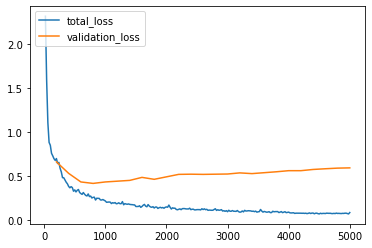

In [32]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output/fake_hail/202203301504_r2'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
#experiment_metrics = load_json_arr('./hail_eval/coco_instances_results.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()

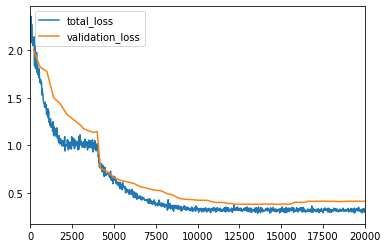

In [33]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output/fake_hail/202203301504_r3'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
#experiment_metrics = load_json_arr('./hail_eval/coco_instances_results.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.xlim([0,20000])
plt.show()

In [36]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultPredictor

experiment_folder = './output/fake_hail/202203301504_r3/'

cfg.MODEL.WEIGHTS = os.path.join(experiment_folder, "model_0012999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.90
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("val_hail", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "val_hail")
inference_on_dataset(trainer.model, val_loader, evaluator)

[05/24 09:06:47 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

[05/24 09:06:47 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [05/24 09:06:47 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/24 09:06:47 d2.data.datasets.coco]: Loaded 31 images in COCO format from ./data/fake_hail/202203301504/val.json
[05/24 09:06:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/24 09:06:47 d2.data.common]: Serializing 31 elements to byte tensors and concatenating them all ...
[05/24 09:06:47 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/24 09:06:47 d2.evaluation.evaluator]: Start inference on 31 batches
[05/24 09:06:48 d2.evaluation.evaluator]: Inference done 11/31. Dataloading: 0.0006 s/iter. Inference: 0.0496 s/iter. Eval: 0.0005 s/iter. Total: 0.0507 s/iter. ETA=0:00:01
[05/24

OrderedDict([('bbox',
              {'AP': 64.36434698412108,
               'AP50': 89.0215492137449,
               'AP75': 85.46884100174724,
               'APs': 64.36434698412108,
               'APm': nan,
               'APl': nan}),
             ('segm',
              {'AP': 68.74232314588335,
               'AP50': 89.0215492137449,
               'AP75': 85.46884100174724,
               'APs': 68.74232314588335,
               'APm': nan,
               'APl': nan})])

In [17]:
from detectron2.utils.visualizer import ColorMode
import numpy as np

instance_path = 'products/202203301504_r3/val_instances/'
if not os.path.exists(instance_path):
    os.makedirs(instance_path)  

for d in dataset_dicts_val:    
    im = cv2.imread(d["file_name"])
    image_name = Path(d["file_name"]).stem
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=hail_metadata_val, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im = v.get_image()
    fig=plt.figure(figsize=[20,20])
    plt.imshow(im)
    plt.savefig(instance_path+'pred_'+image_name+'.png',dpi=300, bbox_inches='tight')
    plt.close()

In [104]:
#Detect hail and save segmentation masks
from detectron2.utils.visualizer import ColorMode
import glob
from pathlib import Path
import pickle
import numpy as np

images_path = 'data/fake_hail/202203301504/images/'
mask_array_path = 'products/202203301504_r3/pkl/'

if not os.path.exists(mask_array_path):
    os.makedirs(mask_array_path)  

all_images = glob.glob(images_path+'*.png')
all_images.sort()

for file in all_images:
    im = cv2.imread(file)
    outputs = predictor(im)
    masks = outputs['instances'][outputs['instances'].pred_classes==0].pred_masks.cpu().numpy()

    image_name = Path(file).stem

    mask_array = []
    #hail_count = 1 # For saving all individual masks to a figure
    for i in range(masks.shape[0]):
        mask_int = masks[i,:,:]*1
        mask_array.append(mask_int)
        
        #hail_area = (mask_int == 1).sum() #1 pixel = 1mm^2
        #hail_areas.append(hail_area)
        #title='Hailstone area: '+str(hail_area)+'mm$^2$'
        #display_images([masks[:,:,i]],mask_path, image_name, hail_count, titles=[title])
        #plt.close('all')
        #hail_count = hail_count + 1

    with open(mask_array_path+'mask_array_'+image_name+'.pkl','wb') as f:
        pickle.dump(mask_array, f)

[]